### 프로젝트 요약 및 회고
#### 프로젝트 요약
- 본 프로젝트는 Seq2Seq를 이용하여, 한국어를 영어로 번역하는 번역기를 개발하는 프로젝트임
- 주어진 데이터를 파악하고, 정제하고, 토큰화한 후,
- Seq2Seq 모델(바닐라모델 및 2개의 Attention 모델)를 설계 및 학습하고 평가하였음.
- 가이드라인에 따라 train 데이터셋은 validation으로 나누지는 않았고, dev 데이터셋을 Validation에 활용함
- 가이드라인에 따라 토큰화는 mecab를 사용하였지만, 추가로 SentencePiece(BPE)로 subword를 하여 토큰화 이후의 분포를 확인함
- seq2seq는 가이드라인에 따라 Bahdanu Attention모델을 포함시켰고, 추가로 Attention이 없는 Vanilla 모델, 효율성이 개선된 Luong Attention 모델을 실험함
#### 프로젝트 회고
- seq2seq 모델은 최근에는 활용도가 높지 않지만, 자연어처리(NLP)를 이해하는 좋은 도구라는 것을 깨닫게 되었다.
- 간단한 데이터만 보다가 복잡한 데이터를 보고, 겁도 났지만 데이터를 끝까지 파악하고자 팀이 함께 고민(수다떨기)한 좋은 프로젝트였다.
- 프로젝트 결과 Bahdanau가 가장 안정적, Luong은 특정 문장에서 “고정 오역 템플릿”이 보이고, Vanilla는 전반적으로 의미 대응이 안되는 것을 발견했습니다.
- 이번 프로젝트를 계기로 좀 더 복잡한 서비스를 기획할 수 있겠다는 자신감이 붙었다.

### Task 확인 및 프로젝트 방향
---
#### Task 확인 : Seq2Seq으로 한-영 번역기 만들기(입력: 한국어, 출력: 영어)
---
### Project Process
---
#### step 1 데이터 다운로드 
- 필요 라이이브러리 import 및 버전확인
- 데이터 다운로드 및 구조 확인(train/dev/test)
- Train: 학습에만 사용,  train dataset를 train/validation으로 나누지 않는다는 가이드라인에 따름
- (실험 안정화를 위해 이후 단계에서 Train의 일부를 validation으로 분리할 수 있음)
- Dev: Validation (early stopping를 위해 사용하지만, 너무 적어서 적절하지 않을 경우 제외하고 Train dataset의 일부(10%)를 분리하여 사용)
- Test: 최종 평가에만 사용
#### step 2 데이터 정제
- Task 목적, 데이터의 특징에 맞게 정제 요소 파악
- (kor, eng) 병렬쌍 유지하며 중복 제거
- 한/영 각각 정규화(특수문자, 공백, 기호 처리 등)
- 정제 전/후 길이 분포 및 품질 점검
- 길이 40 이하 필터링하여 학습 코퍼스 구성
#### step 3 데이터 토큰화
- 가이드 기준: 한국어 mecab, 영어 split + <start>/<end>
- 추가 실험: SentencePiece(BPE)로 subword
- 토큰 길이/어휘 크기 분포 확인, vocab size ≥ 10,000
- 토큰화 후 분포 파악하여 최종 토큰화 방향 결정
#### step 4 모델설계
- Vanilla Seq2Seq
- Bahdanau Attention Seq2Seq
- Luong Attention Seq2Seq
#### step 5 모델학습:
- 동일 조건(epochs/lr/batch/max_len 등)으로 3모델 학습
- 학습 중 샘플 번역 출력 + attention map 시각화
#### Step 6 모델평가
- test dataset 전체에 대해 Corpus BLEU
- 보조 지표로 BLEU + chrF
- 3개 모델 성능 비교 및 에러 분석(짧은 문장/고유명사/부정문 등)
---

### Step 1 라이브러리 블러오기 및 데이터 다운로드
- 필요 라이이브러리 import 및 버전확인
- 데이터 다운로드 및 구조 확인(train/dev/test)
- Train: 학습에만 사용,  train dataset를 train/validation으로 나누지 않는다는 가이드라인에 따름
- Dev: Validation (하이퍼파라미터/early stopping/모델 선택에 사용)
- Test: 최종 평가에만 사용


In [1]:
# [STEP1-CELL 1]  디렉토리 만들기
import os
os.makedirs("s2s_translation", exist_ok=True)
# !mkdir s2s_translation

In [3]:
# ============================================================
#  [STEP1-CELL 2]  Imports + Versions + Device
#   - device
# ============================================================

import os
import re
import urllib.request
import tarfile
from pathlib import Path

import numpy as np
import pandas as pd

import torch

print("torch:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# (선택) 재현성 시드 - 뒤 셀에서 모델 학습 시에도 사용
import random
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(42)

torch: 2.8.0+cu126
device: cuda


In [4]:
# ============================================================
# [STEP1-CELL 3] 폰트 확인 Matplotlib Font (Windows: NanumGothic)
# - 이후 시각화(길이 분포, 어텐션맵 등)에 사용
# ============================================================

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

# Windows 폰트 경로 (당신이 확인한 경로 기반)
font_path = r"C:\Windows\Fonts\NanumGothic.ttf"

if not os.path.exists(font_path):
    raise FileNotFoundError(f"폰트 파일이 없습니다: {font_path}")

fontprop = fm.FontProperties(fname=font_path, size=12)
plt.rcParams["font.family"] = fontprop.get_name()
plt.rcParams["axes.unicode_minus"] = False

print(f"설정된 폰트: {fontprop.get_name()}")

설정된 폰트: NanumGothic


In [5]:
# ============================================================
# [STEP1-CELL 4]  Project Paths (Local Windows)
# - ./s2s_translation 기준으로 저장 구조 확정
#
# - 이후 단계에서 계속 사용할 핵심 변수:
#   - project_root
#   - dataset_root, dl_dir, raw_dir
# ============================================================

# 노트북 실행 위치 확인
print("CWD:", os.getcwd())

# s2s_translation을 절대경로로 고정
project_root = Path("s2s_translation").resolve()
dataset_root = project_root / "datasets" / "ko_en_news_v1"
dl_dir = dataset_root / "downloads"
raw_dir = dataset_root / "raw"

dl_dir.mkdir(parents=True, exist_ok=True)
raw_dir.mkdir(parents=True, exist_ok=True)

print("project_root:", project_root)
print("dataset_root:", dataset_root)
print("dl_dir:", dl_dir)
print("raw_dir:", raw_dir)

CWD: D:\PyProject\AIFFEL_AI\LLM
project_root: D:\PyProject\AIFFEL_AI\LLM\s2s_translation
dataset_root: D:\PyProject\AIFFEL_AI\LLM\s2s_translation\datasets\ko_en_news_v1
dl_dir: D:\PyProject\AIFFEL_AI\LLM\s2s_translation\datasets\ko_en_news_v1\downloads
raw_dir: D:\PyProject\AIFFEL_AI\LLM\s2s_translation\datasets\ko_en_news_v1\raw


In [7]:
# ============================================================
#  [STEP1-CELL 5]  Download utils + URLs (train/dev/test)
# - dev도 함께 다운로드 대상에 포함
#
# - 이후 단계에서 계속 사용할 핵심 변수:
#   - urls (dict)
#   - tar_paths (dict)
# ============================================================

def download(url: str, out_path: Path):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    if out_path.exists():
        print(f"[SKIP] already exists: {out_path.name}")
        return
    print(f"[DOWN] {url}")
    urllib.request.urlretrieve(url, str(out_path))
    print(f"[OK] saved: {out_path}")

urls = {
    "train": "https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz",
    "dev":   "https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.dev.tar.gz",
    "test":  "https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.test.tar.gz",
}

tar_paths = {split: (dl_dir / f"korean-english-park.{split}.tar.gz") for split in urls.keys()}
tar_paths

{'train': WindowsPath('D:/PyProject/AIFFEL_AI/LLM/s2s_translation/datasets/ko_en_news_v1/downloads/korean-english-park.train.tar.gz'),
 'dev': WindowsPath('D:/PyProject/AIFFEL_AI/LLM/s2s_translation/datasets/ko_en_news_v1/downloads/korean-english-park.dev.tar.gz'),
 'test': WindowsPath('D:/PyProject/AIFFEL_AI/LLM/s2s_translation/datasets/ko_en_news_v1/downloads/korean-english-park.test.tar.gz')}

In [11]:
# ============================================================
# [STEP1-CELL 6]  Download
# ============================================================

for split, url in urls.items():
    download(url, tar_paths[split])

# ============================================================
# [ 6] Extract (.tar.gz)
# - raw/train_raw, raw/dev_raw, raw/test_raw 로 분리
# - 이미 풀려 있으면 스킵
#
# - 이후 단계에서 계속 사용할 핵심 변수:
#   - split_raw_dirs (dict)
# ============================================================

def extract_tar_gz(tar_path: Path, extract_dir: Path):
    extract_dir.mkdir(parents=True, exist_ok=True)
    # 이미 풀린 흔적이 있으면 스킵
    if any(extract_dir.iterdir()):
        print(f"[SKIP] already extracted: {extract_dir}")
        return
    print(f"[EXTR] {tar_path.name} -> {extract_dir}")
    with tarfile.open(str(tar_path), "r:gz") as tar:
        tar.extractall(path=str(extract_dir))
    print("[OK] extracted")

split_raw_dirs = {split: (raw_dir / f"{split}_raw") for split in urls.keys()}
split_raw_dirs

for split in urls.keys():
    extract_tar_gz(tar_paths[split], split_raw_dirs[split])

[SKIP] already exists: korean-english-park.train.tar.gz
[SKIP] already exists: korean-english-park.dev.tar.gz
[SKIP] already exists: korean-english-park.test.tar.gz
[SKIP] already extracted: D:\PyProject\AIFFEL_AI\LLM\s2s_translation\datasets\ko_en_news_v1\raw\train_raw
[SKIP] already extracted: D:\PyProject\AIFFEL_AI\LLM\s2s_translation\datasets\ko_en_news_v1\raw\dev_raw
[SKIP] already extracted: D:\PyProject\AIFFEL_AI\LLM\s2s_translation\datasets\ko_en_news_v1\raw\test_raw


In [13]:
# ============================================================
# [STEP1-CELL 7]  Load parallel data (Kor/Eng pair 유지)
# - 컬럼명: kor, eng (고정)
# - 변수명: 소문자 통일 (train_df, dev_df, test_df)
#
# - 이후 단계에서 계속 사용할 핵심 변수:
#   - train_df, dev_df, test_df
# ============================================================

def _find_exact_pair(raw_dir: Path, split: str):
    """
    split(train/dev/test)이 파일명에 포함되고 확장자가 .ko/.en 인 파일을 찾는다.
    """
    all_files = []
    for root, _, files in os.walk(raw_dir):
        for fn in files:
            all_files.append(Path(root) / fn)

    # split 문자열이 들어간 .ko / .en
    ko_files = [p for p in all_files if p.suffix.lower() == ".ko" and split.lower() in p.name.lower()]
    en_files = [p for p in all_files if p.suffix.lower() == ".en" and split.lower() in p.name.lower()]

    if not ko_files or not en_files:
        raise FileNotFoundError(f"[{split}] .ko/.en files not found under: {raw_dir}")

    # 일반적으로 1개씩이므로 가장 짧은 경로 우선
    ko_path = sorted(ko_files, key=lambda x: (len(str(x)), str(x)))[0]
    en_path = sorted(en_files, key=lambda x: (len(str(x)), str(x)))[0]
    return ko_path, en_path

def load_parallel_df(raw_dir: Path, split: str) -> pd.DataFrame:
    ko_path, en_path = _find_exact_pair(raw_dir, split)

    with open(ko_path, "r", encoding="utf-8") as f:
        kor_lines = [line.rstrip("\n") for line in f]
    with open(en_path, "r", encoding="utf-8") as f:
        eng_lines = [line.rstrip("\n") for line in f]

    n = min(len(kor_lines), len(eng_lines))
    if len(kor_lines) != len(eng_lines):
        print(f"[WARN] line mismatch: Kor={len(kor_lines)}, Eng={len(eng_lines)} -> using first {n}")

    df = pd.DataFrame({"kor": kor_lines[:n], "eng": eng_lines[:n]})

    # --- sanity check ---
    sample = df.head(200)
    kor_h = sample["kor"].str.count(r"[가-힣]").mean()
    eng_h = sample["eng"].str.count(r"[가-힣]").mean()

    print(f"\n[LOAD] split={split}")
    print(f" - Kor file: {ko_path}")
    print(f" - Eng file: {en_path}")
    print(f"[CHECK] avg hangul count | Kor={kor_h:.2f} | Eng={eng_h:.2f}")

    if kor_h < 0.5:
        print("⚠️  kor 컬럼이 한국어가 아닐 가능성이 큽니다. (파일 매칭 확인 필요)")
    if eng_h > 0.5:
        print("⚠️  eng 컬럼에 한글이 과하게 섞여 있습니다. (파일 매칭 확인 필요)")

    return df

train_df = load_parallel_df(split_raw_dirs["train"], "train")
dev_df   = load_parallel_df(split_raw_dirs["dev"],   "dev")
test_df  = load_parallel_df(split_raw_dirs["test"],  "test")

print("\n[OK] DataFrames ready.")
print("train_df:", train_df.shape, "| columns:", train_df.columns.tolist())
print("dev_df  :", dev_df.shape,   "| columns:", dev_df.columns.tolist())
print("test_df :", test_df.shape,  "| columns:", test_df.columns.tolist())

display(train_df.head(3))
display(dev_df.head(3))
display(test_df.head(3))


[LOAD] split=train
 - Kor file: D:\PyProject\AIFFEL_AI\LLM\s2s_translation\datasets\ko_en_news_v1\raw\train_raw\korean-english-park.train.ko
 - Eng file: D:\PyProject\AIFFEL_AI\LLM\s2s_translation\datasets\ko_en_news_v1\raw\train_raw\korean-english-park.train.en
[CHECK] avg hangul count | Kor=49.84 | Eng=0.00

[LOAD] split=dev
 - Kor file: D:\PyProject\AIFFEL_AI\LLM\s2s_translation\datasets\ko_en_news_v1\raw\dev_raw\korean-english-park.dev.ko
 - Eng file: D:\PyProject\AIFFEL_AI\LLM\s2s_translation\datasets\ko_en_news_v1\raw\dev_raw\korean-english-park.dev.en
[CHECK] avg hangul count | Kor=47.09 | Eng=0.00

[LOAD] split=test
 - Kor file: D:\PyProject\AIFFEL_AI\LLM\s2s_translation\datasets\ko_en_news_v1\raw\test_raw\korean-english-park.test.ko
 - Eng file: D:\PyProject\AIFFEL_AI\LLM\s2s_translation\datasets\ko_en_news_v1\raw\test_raw\korean-english-park.test.en
[CHECK] avg hangul count | Kor=49.48 | Eng=0.00

[OK] DataFrames ready.
train_df: (94123, 2) | columns: ['kor', 'eng']
dev_df  

,kor,eng
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."


,kor,eng
0,세계 에서 가장 강력한 수퍼컴퓨터를 1년 동안이나 독점해 오던 정부의 연구학자들이 ...,After keeping the world's most powerful superc...
1,초당 12조3천억 번의 계산을 수행할수 있는 능력이 있는 로렌스 리버모아 국립 연구...,With the ability to perform 12.3 trillion calc...
2,미국은 1992년에 지하 핵실험을 중지시켰기 때문에 이러한 모의 실험은 한 치의 오...,Those simulations must be as precise as possib...


,kor,eng
0,토론에 참여한 사람들은 법 집행과 국가 안전보장에 대한 우려를 표명해야 할 필요성을...,Those involved in the discussions do take seri...
1,"또한 새로운 기술 개발이 어떤 해결책을 제공해 주는데 도움이 될 것이고, 동시 에 ...",There is also some hope that new technology de...
2,그래서 클리퍼 칩에 대한 개인적인 해결책은 서서히 자취를 감출 것입니다. 그러나 이...,So the individual solution of the clipper chip...


In [15]:
# ============================================================
# [STEP1-CELL 8]  Pre-Clean Distribution Summary (train/dev(val)/test)
# - 정제 전 데이터 상태를 근거로 파악
# - 중복률(특히 train 16%) 확인
#
# 사용 변수:
#   train_df, dev_df, test_df
# 산출:
#   pre_stats (dict)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

def summarize_split(df, name="train"):
    n = len(df)
    kor_char = df["kor"].astype(str).str.len()
    eng_char = df["eng"].astype(str).str.len()
    kor_tok  = df["kor"].astype(str).str.split().str.len()
    eng_tok  = df["eng"].astype(str).str.split().str.len()

    dup = df.duplicated(subset=["kor","eng"]).sum()
    kor_hangul_ratio = df["kor"].astype(str).str.count(r"[가-힣]").sum() / df["kor"].astype(str).str.len().sum()
    eng_hangul_ratio = df["eng"].astype(str).str.count(r"[가-힣]").sum() / df["eng"].astype(str).str.len().sum()

    summary = {
        "name": name,
        "n": n,
        "dup_pairs": int(dup),
        "dup_ratio": float(dup / max(1,n)),
        "kor_char_min": float(kor_char.min()),
        "kor_char_med": float(kor_char.median()),
        "kor_char_mean": float(kor_char.mean()),
        "kor_char_max": float(kor_char.max()),
        "eng_char_min": float(eng_char.min()),
        "eng_char_med": float(eng_char.median()),
        "eng_char_mean": float(eng_char.mean()),
        "eng_char_max": float(eng_char.max()),
        "kor_tok_min": float(kor_tok.min()),
        "kor_tok_med": float(kor_tok.median()),
        "kor_tok_mean": float(kor_tok.mean()),
        "kor_tok_max": float(kor_tok.max()),
        "eng_tok_min": float(eng_tok.min()),
        "eng_tok_med": float(eng_tok.median()),
        "eng_tok_mean": float(eng_tok.mean()),
        "eng_tok_max": float(eng_tok.max()),
        "kor_hangul_ratio": float(kor_hangul_ratio),
        "eng_hangul_ratio": float(eng_hangul_ratio),
        # 분포 시각화용
        "kor_tok_series": kor_tok,
        "eng_tok_series": eng_tok,
    }

    print(f"\n==================== {name.upper()} ====================")
    print(f"Total sentence pairs: {n}")
    print(f"Duplicate pairs: {dup} ({dup/max(1,n)*100:.2f}%)")
    print(f"Hangul ratio | Kor={kor_hangul_ratio:.4f} | Eng={eng_hangul_ratio:.4f}")
    print("Kor token len (ws)  :", {"min": summary["kor_tok_min"], "50%": summary["kor_tok_med"], "mean": summary["kor_tok_mean"], "max": summary["kor_tok_max"]})
    print("Eng token len (ws)  :", {"min": summary["eng_tok_min"], "50%": summary["eng_tok_med"], "mean": summary["eng_tok_mean"], "max": summary["eng_tok_max"]})
    print("Kor char len        :", {"min": summary["kor_char_min"], "50%": summary["kor_char_med"], "mean": summary["kor_char_mean"], "max": summary["kor_char_max"]})
    print("Eng char len        :", {"min": summary["eng_char_min"], "50%": summary["eng_char_med"], "mean": summary["eng_char_mean"], "max": summary["eng_char_max"]})

    return summary

pre_stats = {
    "train": summarize_split(train_df, "train"),
    "dev":   summarize_split(dev_df,   "dev(val)"),
    "test":  summarize_split(test_df,  "test"),
}


==================== TRAIN ====================
Total sentence pairs: 94123
Duplicate pairs: 15155 (16.10%)
Hangul ratio | Kor=0.6845 | Eng=0.0000
Kor token len (ws)  : {'min': 1.0, '50%': 14.0, 'mean': 14.047066073117092, 'max': 82.0}
Eng token len (ws)  : {'min': 1.0, '50%': 20.0, 'mean': 20.896688375848623, 'max': 90.0}
Kor char len        : {'min': 1.0, '50%': 59.0, 'mean': 60.78048935966767, 'max': 377.0}
Eng char len        : {'min': 1.0, '50%': 121.0, 'mean': 126.10869819279029, 'max': 605.0}

==================== DEV(VAL) ====================
Total sentence pairs: 1000
Duplicate pairs: 0 (0.00%)
Hangul ratio | Kor=0.6903 | Eng=0.0000
Kor token len (ws)  : {'min': 1.0, '50%': 15.0, 'mean': 15.094, 'max': 44.0}
Eng token len (ws)  : {'min': 1.0, '50%': 21.0, 'mean': 22.147, 'max': 64.0}
Kor char len        : {'min': 4.0, '50%': 64.0, 'mean': 66.128, 'max': 183.0}
Eng char len        : {'min': 11.0, '50%': 126.0, 'mean': 133.593, 'max': 416.0}

==================== TEST =========

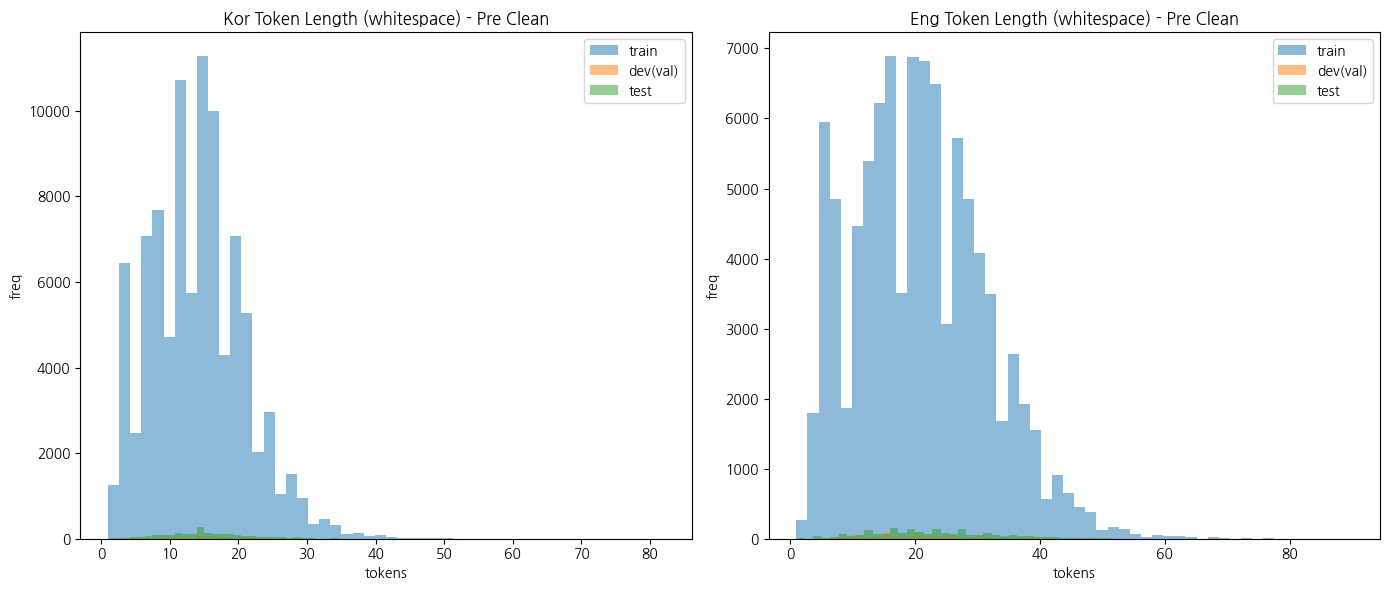

In [17]:
# ============================================================
# [STEP1-CELL 9] Pre-Clean Token Length Distribution (Side-by-Side)
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Kor
axes[0].hist(pre_stats["train"]["kor_tok_series"], bins=50, alpha=0.5, label="train")
axes[0].hist(pre_stats["dev"]["kor_tok_series"],   bins=50, alpha=0.5, label="dev(val)")
axes[0].hist(pre_stats["test"]["kor_tok_series"],  bins=50, alpha=0.5, label="test")
axes[0].set_title("Kor Token Length (whitespace) - Pre Clean")
axes[0].set_xlabel("tokens"); axes[0].set_ylabel("freq")
axes[0].legend()

# Eng
axes[1].hist(pre_stats["train"]["eng_tok_series"], bins=50, alpha=0.5, label="train")
axes[1].hist(pre_stats["dev"]["eng_tok_series"],   bins=50, alpha=0.5, label="dev(val)")
axes[1].hist(pre_stats["test"]["eng_tok_series"],  bins=50, alpha=0.5, label="test")
axes[1].set_title("Eng Token Length (whitespace) - Pre Clean")
axes[1].set_xlabel("tokens"); axes[1].set_ylabel("freq")
axes[1].legend()

plt.tight_layout()
plt.show()


## step 2 데이터 전처리: 데이터 정제
- Task 목적, 데이터의 특징에 맞게 정제 요소 파악
- (kor, eng) 병렬쌍 유지하며 중복 제거
- 한/영 각각 정규화(특수문자, 공백, 기호 처리 등)
- 정제 전/후 길이 분포 및 품질 점검
- 길이 40 이하 필터링하여 학습 코퍼스 구성

In [20]:
# ============================================================
# [STEP2-CELL 1] Korean->English 번역 데이터 정제 파이프라인 (Sentence-level)
# - 기사/학습노트 혼합 데이터 대응
# - 1:1 정렬 유지 + pair 품질 필터 + 중복 제거
# - 한국어 입력은 "한국어 문장" 중심(약어/고유명사 OK)
# - 토큰 길이 40 이하 선별
# ============================================================

import re
import unicodedata
from html import unescape
from typing import List, Tuple, Iterable, Optional

# -----------------------------
# 0) 공통 유틸
# -----------------------------
ZW_CHARS = r"[\u200b\u200c\u200d\u2060\ufeff]"  # zero-width, BOM

def normalize_nfkc(text: str) -> str:
    return unicodedata.normalize("NFKC", text)

def strip_control_and_spaces(text: str) -> str:
    # 제어문자(개행/탭 제외) 제거
    text = re.sub(r"[\x00-\x08\x0b\x0c\x0e-\x1f]", " ", text)
    # zero-width 제거
    text = re.sub(ZW_CHARS, "", text)
    # 공백 정리
    text = re.sub(r"\s+", " ", text).strip()
    return text

def html_clean(text: str) -> str:
    # HTML 엔티티 복원 + 태그 제거
    text = unescape(text)
    text = re.sub(r"<\s*br\s*/?\s*>", " ", text, flags=re.I)
    text = re.sub(r"<[^>]+>", " ", text)
    return text

def normalize_punct(text: str) -> str:
    # 따옴표/아포스트로피
    text = re.sub(r"[“”„]", '"', text)
    text = re.sub(r"[‘’´`]", "'", text)

    # 대시/하이픈
    text = re.sub(r"[—–−]", "-", text)

    # 줄임표
    text = text.replace("…", "...")

    # 불필요 특수문자(프로젝트 기준)
    text = re.sub(r"[\*_]", " ", text)

    # 괄호는 유지(정책: 유지)하되 공백 정리
    text = re.sub(r"\s+", " ", text).strip()
    return text

def remove_url_email(text: str) -> str:
    text = re.sub(r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}", " ", text)
    text = re.sub(r"https?://\S+|www\.\S+", " ", text)
    return text

# -----------------------------
# 1) 메타 제거(뉴스/학습노트)
# -----------------------------
META_PATTERNS_KO = [
    r"[가-힣]{2,4}\s*기자",                           # 기자명
    r"\([^)]*(뉴스|로이터|AP|AFP|통신|연합|JOINS)[^)]*\)",  # 출처 괄호
    r"원문\s*&\s*독해설명.*",                         # 학습자료 라벨
    r"영한사전\s*약어표.*|한영사전\s*약어표.*",
]

META_PATTERNS_EN = [
    r"^\s*by\s+[a-zA-Z]+\s+[a-zA-Z]+.*",             # By John Doe...
    r"\([^)]*(reuters|ap|afp|news)[^)]*\)",          # (Reuters)
]

# 영어 학습노트/단어장 느낌(한국어 문장에 섞인 영어 라인 제거)
EN_NOTE_LINE = re.compile(
    r"^\s*([a-zA-Z][a-zA-Z0-9'\"().,\-:/ ]{2,})\s*$"
)

def remove_meta_ko(text: str) -> str:
    for pat in META_PATTERNS_KO:
        text = re.sub(pat, " ", text)
    return text

def remove_meta_en(text: str) -> str:
    for pat in META_PATTERNS_EN:
        text = re.sub(pat, " ", text, flags=re.I)
    return text

# -----------------------------
# 2) 언어 혼합 처리
#    - KO: 약어/고유명사는 OK
#    - KO가 "영어 문장 라인"이면 제거(필터)
# -----------------------------
def is_mostly_english_sentence(text: str) -> bool:
    # 글자 비율 기반으로 "거의 영어 문장" 탐지
    # (한국어 번역 입력으로 부적합한 라인 제거 목적)
    if not text:
        return True
    letters = re.findall(r"[A-Za-z]", text)
    hangul = re.findall(r"[가-힣]", text)
    # 영어가 많고 한글이 거의 없으면 영어 문장으로 간주
    if len(letters) >= 8 and len(hangul) <= 1:
        return True
    return False

# -----------------------------
# 2-b) EN 기준 필터 
# -----------------------------
def is_mostly_korean_sentence(text: str) -> bool:
    """EN 라인에 한글이 꽤 섞이면(영어 번역문이 아니면) 제거"""
    if not text:
        return True
    hangul = re.findall(r"[가-힣]", text)
    letters = re.findall(r"[A-Za-z]", text)
    if len(hangul) >= 3 and len(letters) <= 1:
        return True
    return False

def looks_like_vocab_or_note_en(text: str) -> bool:
    """
    EN 라인이 번역문이 아니라 단어장/학습노트/설명문 형태인지 탐지
    - ~ placeholder
    - 'phrase : meaning' / 'word - meaning' 류
    - 괄호만 있는 라인
    - 기호 과다
    - 너무 짧은 조각
    """
    if not text:
        return True

    t = text.strip()

    # placeholder / 정의 기호
    if re.search(r"[~≈⇒→]|==>|=>", t):
        return True

    # 사전식: "phrase - ..." 또는 "phrase : ..."
    if re.search(r"\b[a-zA-Z][a-zA-Z' ]{1,}\s*[-:]\s*[a-zA-Z]", t):
        left = re.split(r"[-:]", t, maxsplit=1)[0].strip()
        if 1 <= len(left.split()) <= 5:
            return True

    # 괄호만 있는 설명
    if re.fullmatch(r"\([^)]{1,80}\)", t):
        return True

    # 기호 과다(사전/메모 느낌)
    if t.count(";") >= 2 or t.count("/") >= 3:
        return True

    # 1~3 단어 조각(종결부호 없으면 노트일 확률↑)
    if len(t.split()) <= 3 and not re.search(r"[.!?]$", t):
        return True

    return False

def is_english_sentence_like(
    text: str,
    min_alpha_ratio: float = 0.6,
    min_words: int = 2,
    require_terminal_punct: bool = False,
) -> bool:
    """
    영어 문장 형태 최소 조건:
    - 최소 단어수
    - 알파벳 비율(기호/숫자만 있는 라인 제거)
    - (옵션) 문장 종결부호
    """
    if not text:
        return False
    t = text.strip()
    words = t.split()
    if len(words) < min_words:
        return False

    total_chars = len(re.sub(r"\s+", "", t))
    alpha_chars = len(re.findall(r"[A-Za-z]", t))
    if total_chars == 0:
        return False
    if (alpha_chars / total_chars) < min_alpha_ratio:
        return False

    if require_terminal_punct and not re.search(r"[.!?]$", t):
        return False

    return True

def preprocess_ko_sentence(text: str) -> str:
    text = normalize_nfkc(text)
    text = html_clean(text)
    text = remove_url_email(text)
    text = normalize_punct(text)
    text = remove_meta_ko(text)
    text = strip_control_and_spaces(text)

    # 허용 문자 제한(한글/영어/숫자/기본 구두점/괄호/따옴표)
    text = re.sub(r"[^가-힣A-Za-z0-9?.!,()\"'\-/% ]+", " ", text)
    text = strip_control_and_spaces(text)

    # 빈 괄호 제거(옵션)
    text = re.sub(r"\(\s*\)", " ", text)
    text = strip_control_and_spaces(text)
    return text

def preprocess_en_sentence(text: str) -> str:
    text = normalize_nfkc(text)
    text = html_clean(text)
    text = remove_url_email(text)
    text = normalize_punct(text)
    text = remove_meta_en(text)
    text = strip_control_and_spaces(text)

    text = text.lower()
    # 허용 문자 제한
    text = re.sub(r"[^a-z0-9?.!,()\"'\-/% ]+", " ", text)
    text = strip_control_and_spaces(text)

    # 빈 괄호 제거(옵션)
    text = re.sub(r"\(\s*\)", " ", text)
    text = strip_control_and_spaces(text)
    return text

# -----------------------------
# 3) 문장 분리
# -----------------------------
SENT_SPLIT = re.compile(r"(?<=[\.\?\!])\s+")

def split_into_sentences(text: str) -> List[str]:
    text = strip_control_and_spaces(text.replace("\n", " "))
    if not text:
        return []
    parts = SENT_SPLIT.split(text)
    parts = [p.strip() for p in parts if p.strip()]
    return parts

# -----------------------------
# 4) 품질 필터(1:1 정렬)
# -----------------------------
def is_good_pair(ko: str, en: str,
                 min_chars: int = 2,
                 ratio_min: float = 0.3,
                 ratio_max: float = 3.5) -> bool:
    if not ko or not en:
        return False

    if len(ko) < min_chars or len(en) < min_chars:
        return False

    # 복사/동일 제거(대소문자/공백 무시)
    if re.sub(r"\s+", "", ko).lower() == re.sub(r"\s+", "", en).lower():
        return False

    # 길이 비율(글자수 기준)
    r = len(ko) / max(1, len(en))
    if r < ratio_min or r > ratio_max:
        return False

    return True

# -----------------------------
# 5) 토큰 길이 제한(<= 40)
# -----------------------------
def get_mecab_tokenizer():
    try:
        from konlpy.tag import Mecab
        return Mecab()
    except Exception:
        return None

def token_len_ko(text: str, mecab=None) -> int:
    if not text:
        return 0
    if mecab is not None:
        return len(mecab.morphs(text))
    return len(text.split())

def token_len_en(text: str) -> int:
    if not text:
        return 0
    return len(text.split())

# -----------------------------
# 6) 메인: 라인(pair) 단위 정제 + 중복 제거 + 길이 필터
# -----------------------------
def clean_parallel_corpus(
    raw_pairs: Iterable[Tuple[str, str]],
    max_tokens: int = 40,
    do_sentence_split: bool = False,
    drop_ko_english_sentences: bool = True,
    drop_en_non_sentence: bool = True,              # (추가) EN 문장성 필터 on/off
    en_require_terminal_punct: bool = False,        # (추가) EN 종결부호 강제 옵션
) -> List[Tuple[str, str]]:
    """
    raw_pairs: (ko_line, en_line) iterable
    returns: cleaned list of (ko, en)
    """
    mecab = get_mecab_tokenizer()

    seen = set()
    cleaned = []

    for ko_raw, en_raw in raw_pairs:
        if ko_raw is None or en_raw is None:
            continue

        if do_sentence_split:
            ko_sents = split_into_sentences(ko_raw)
            en_sents = split_into_sentences(en_raw)
            if len(ko_sents) != len(en_sents):
                continue
            pairs = zip(ko_sents, en_sents)
        else:
            pairs = [(ko_raw, en_raw)]

        for ko, en in pairs:
            ko = preprocess_ko_sentence(ko)
            en = preprocess_en_sentence(en)

            # KO에 "영어 문장 라인"이 들어오면 제거(정책)
            if drop_ko_english_sentences and is_mostly_english_sentence(ko):
                continue

            # -----------------------------
            # EN 기준 추가 필터 (핵심 추가)
            # -----------------------------
            if drop_en_non_sentence:
                if is_mostly_korean_sentence(en):
                    continue
                if looks_like_vocab_or_note_en(en):
                    continue
                if not is_english_sentence_like(en, require_terminal_punct=en_require_terminal_punct):
                    continue

            # 품질 필터(정렬/비율/복사)
            if not is_good_pair(ko, en):
                continue

            # 길이 필터(토큰)
            if token_len_ko(ko, mecab) > max_tokens:
                continue
            if token_len_en(en) > max_tokens:
                continue

            # 중복 제거(pair 단위)
            key = (ko, en)
            if key in seen:
                continue
            seen.add(key)

            cleaned.append((ko, en))

    return cleaned

# -----------------------------
# 7) 학습용 코퍼스 구성
# -----------------------------
def build_train_corpus(cleaned_pairs: List[Tuple[str, str]]) -> Tuple[List[str], List[str]]:
    kor_corpus = []
    eng_corpus = []
    for ko, en in cleaned_pairs:
        kor_corpus.append(ko)
        eng_corpus.append(f"<start> {en} <end>")
    return kor_corpus, eng_corpus

# ============================================================
# 사용 예
# ============================================================
if __name__ == "__main__":
    raw_pairs = [
        ("국제유가가 3일(현지시간) 146달러에 육박했다.", "Crude oil prices neared 146 dollars on Thursday."),
        ("what's in it for ~ ~에게 좋은 일(이익)이 있나", "what's in it for ~ is it beneficial?"),
    ]

    cleaned = clean_parallel_corpus(
        raw_pairs,
        max_tokens=40,
        do_sentence_split=False,
        drop_ko_english_sentences=True,
        drop_en_non_sentence=True,
        en_require_terminal_punct=False,
    )
    kor_corpus, eng_corpus = build_train_corpus(cleaned)

    print("cleaned_pairs:", cleaned)
    print("kor_corpus:", kor_corpus)
    print("eng_corpus:", eng_corpus)

cleaned_pairs: [('국제유가가 3일(현지시간) 146달러에 육박했다.', 'crude oil prices neared 146 dollars on thursday.'), ("what's in it for 에게 좋은 일(이익)이 있나", "what's in it for is it beneficial?")]
kor_corpus: ['국제유가가 3일(현지시간) 146달러에 육박했다.', "what's in it for 에게 좋은 일(이익)이 있나"]
eng_corpus: ['<start> crude oil prices neared 146 dollars on thursday. <end>', "<start> what's in it for is it beneficial? <end>"]


In [22]:
# ============================================================
# [STEP2-CELL 2] Cleaning Options
# - 토큰 최대 길이 40, 한글과 영어 함께 제거 원칙
# ============================================================

clean_cfg = {
    "max_tokens": 40,
    "do_sentence_split": False,
    "drop_ko_english_sentences": True,
    "drop_en_non_sentence": True,
    "en_require_terminal_punct": False,
}

print("clean_cfg =", clean_cfg)

clean_cfg = {'max_tokens': 40, 'do_sentence_split': False, 'drop_ko_english_sentences': True, 'drop_en_non_sentence': True, 'en_require_terminal_punct': False}


In [24]:
# ============================================================
# [STEP2-CELL 3] Clean train/dev/test 각각 실행
# - dev(val)도 포함해서 동일 정제 적용
#
# 산출:
#   clean_train_df, clean_dev_df, clean_test_df
# ============================================================

import pandas as pd

def clean_df(df, name="train", clean_cfg=None):
    df_ = df.copy()
    raw_pairs = list(zip(df_["kor"].astype(str), df_["eng"].astype(str)))

    cleaned_pairs = clean_parallel_corpus(
        raw_pairs,
        max_tokens=clean_cfg["max_tokens"],
        do_sentence_split=clean_cfg["do_sentence_split"],
        drop_ko_english_sentences=clean_cfg["drop_ko_english_sentences"],
        drop_en_non_sentence=clean_cfg["drop_en_non_sentence"],
        en_require_terminal_punct=clean_cfg["en_require_terminal_punct"],
    )

    clean_df_ = pd.DataFrame(cleaned_pairs, columns=["kor","eng"])

    print(f"\n===== {name.upper()} CLEAN RESULT =====")
    print(f"raw: {len(df_)}")
    print(f"cleaned: {len(clean_df_)}")
    print(f"removed: {len(df_) - len(clean_df_)}")
    return clean_df_

clean_train_df = clean_df(train_df, "train", clean_cfg)
clean_dev_df   = clean_df(dev_df,   "dev(val)", clean_cfg)
clean_test_df  = clean_df(test_df,  "test", clean_cfg)

display(clean_train_df.head(3))
display(clean_dev_df.head(3))
display(clean_test_df.head(3))


===== TRAIN CLEAN RESULT =====
raw: 94123
cleaned: 66658
removed: 27465

===== DEV(VAL) CLEAN RESULT =====
raw: 1000
cleaned: 888
removed: 112

===== TEST CLEAN RESULT =====
raw: 2000
cleaned: 1691
removed: 309


,kor,eng
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"like all optical mice, but it also doesn't nee..."


,kor,eng
0,세계 에서 가장 강력한 수퍼컴퓨터를 1년 동안이나 독점해 오던 정부의 연구학자들이 ...,after keeping the world's most powerful superc...
1,초당 12조3천억 번의 계산을 수행할수 있는 능력이 있는 로렌스 리버모아 국립 연구...,with the ability to perform 12.3 trillion calc...
2,미국은 1992년에 지하 핵실험을 중지시켰기 때문에 이러한 모의 실험은 한 치의 오...,those simulations must be as precise as possib...


,kor,eng
0,토론에 참여한 사람들은 법 집행과 국가 안전보장에 대한 우려를 표명해야 할 필요성을...,those involved in the discussions do take seri...
1,"또한 새로운 기술 개발이 어떤 해결책을 제공해 주는데 도움이 될 것이고, 동시 에 ...",there is also some hope that new technology de...
2,그래서 클리퍼 칩에 대한 개인적인 해결책은 서서히 자취를 감출 것입니다. 그러나 이...,so the individual solution of the clipper chip...


In [25]:
# ============================================================
# [STEP2-CELL 4] Post-Clean Distribution Summary
# - 정제 후 분포가 어떻게 바뀌었는지 확인
# - 중복 제거가 train에 얼마나 기여했는지 확인
#
# 산출:
#   post_stats (dict)
# ============================================================

post_stats = {
    "train": summarize_split(clean_train_df, "train (clean)"),
    "dev":   summarize_split(clean_dev_df,   "dev(val) (clean)"),
    "test":  summarize_split(clean_test_df,  "test (clean)"),
}


==================== TRAIN (CLEAN) ====================
Total sentence pairs: 66658
Duplicate pairs: 0 (0.00%)
Hangul ratio | Kor=0.6890 | Eng=0.0000
Kor token len (ws)  : {'min': 1.0, '50%': 14.0, 'mean': 14.662351105643733, 'max': 40.0}
Eng token len (ws)  : {'min': 2.0, '50%': 20.0, 'mean': 20.90415253983018, 'max': 40.0}
Kor char len        : {'min': 5.0, '50%': 62.0, 'mean': 63.31225059257704, 'max': 220.0}
Eng char len        : {'min': 9.0, '50%': 122.0, 'mean': 125.69246001980258, 'max': 313.0}

==================== DEV(VAL) (CLEAN) ====================
Total sentence pairs: 888
Duplicate pairs: 0 (0.00%)
Hangul ratio | Kor=0.6925 | Eng=0.0000
Kor token len (ws)  : {'min': 3.0, '50%': 14.5, 'mean': 14.897522522522523, 'max': 39.0}
Eng token len (ws)  : {'min': 3.0, '50%': 20.0, 'mean': 21.10472972972973, 'max': 40.0}
Kor char len        : {'min': 14.0, '50%': 63.0, 'mean': 65.09121621621621, 'max': 183.0}
Eng char len        : {'min': 20.0, '50%': 122.0, 'mean': 127.11148648648

In [26]:
# ============================================================
# [STEP2-CELL 5] Pre vs Post 비교표
# ============================================================

def compact_report(pre, post, key):
    return {
        "split": key,
        "raw_n": pre[key]["n"],
        "clean_n": post[key]["n"],
        "removed": pre[key]["n"] - post[key]["n"],
        "dup_raw(%)": pre[key]["dup_ratio"]*100,
        "dup_clean(%)": post[key]["dup_ratio"]*100,
        "kor_tok_mean_raw": pre[key]["kor_tok_mean"],
        "kor_tok_mean_clean": post[key]["kor_tok_mean"],
        "eng_tok_mean_raw": pre[key]["eng_tok_mean"],
        "eng_tok_mean_clean": post[key]["eng_tok_mean"],
        "kor_tok_max_raw": pre[key]["kor_tok_max"],
        "kor_tok_max_clean": post[key]["kor_tok_max"],
        "eng_tok_max_raw": pre[key]["eng_tok_max"],
        "eng_tok_max_clean": post[key]["eng_tok_max"],
    }

rows = [
    compact_report(pre_stats, post_stats, "train"),
    compact_report(pre_stats, post_stats, "dev"),
    compact_report(pre_stats, post_stats, "test"),
]

report_df = pd.DataFrame(rows)
display(report_df)

,split,raw_n,clean_n,removed,dup_raw(%),dup_clean(%),kor_tok_mean_raw,kor_tok_mean_clean,eng_tok_mean_raw,eng_tok_mean_clean,kor_tok_max_raw,kor_tok_max_clean,eng_tok_max_raw,eng_tok_max_clean
0,train,94123,66658,27465,16.101272,0.0,14.047066,14.662351,20.896688,20.904153,82.0,40.0,90.0,40.0
1,dev,1000,888,112,0.000000,0.0,15.094000,14.897523,22.147000,21.104730,44.0,39.0,64.0,40.0
2,test,2000,1691,309,0.200000,0.0,15.409000,15.259610,22.840000,21.648729,55.0,40.0,69.0,40.0


###  step 2. 데이터 정제 정리
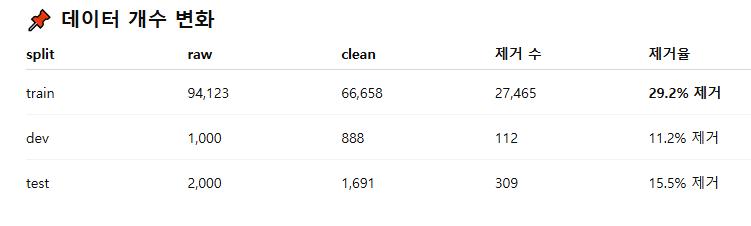
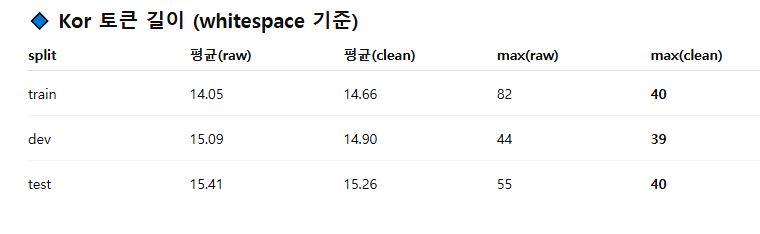
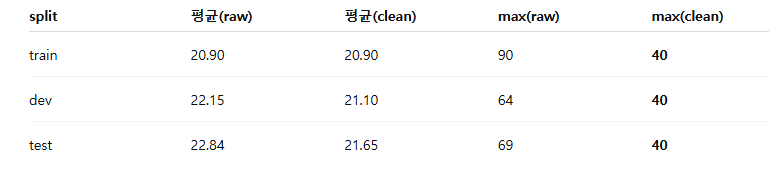

## step 3 데이터 토큰화
- 가이드 기준: 한국어 mecab, 영어 split + <start>/<end> -> Kor = whitespace 토큰화로 대체, Eng = whitespace 토큰화(+ start/end)
- SentencePiece(BPE)로 subword로 대체
- 토큰 길이/어휘 크기 분포 확인, vocab size ≥ 10,000
- 토큰화 후 분포 파악하여 최종 토큰화 방향 결정

In [27]:
# ============================================================
# [STEP3-CELL 1] Build corpora (Kor/Eng) with <start>/<end> for Eng
# - Step3 전체에서 계속 사용할 변수:
#   - train_kor, train_eng
#   - dev_kor, dev_eng
#   - test_kor, test_eng
# ============================================================

def add_start_end(eng: str) -> str:
    return f"<start> {eng} <end>"

train_kor = clean_train_df["kor"].astype(str).tolist()
train_eng = clean_train_df["eng"].astype(str).apply(add_start_end).tolist()

dev_kor   = clean_dev_df["kor"].astype(str).tolist()
dev_eng   = clean_dev_df["eng"].astype(str).apply(add_start_end).tolist()

test_kor  = clean_test_df["kor"].astype(str).tolist()
test_eng  = clean_test_df["eng"].astype(str).apply(add_start_end).tolist()

print("train:", len(train_kor), len(train_eng))
print("dev  :", len(dev_kor), len(dev_eng))
print("test :", len(test_kor), len(test_eng))

print("\n[Sample]")
print("Kor:", train_kor[0])
print("Eng:", train_eng[0])

train: 66658 66658
dev  : 888 888
test : 1691 1691

[Sample]
Kor: 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
Eng: <start> much of personal computing is about "can you top this?" <end>


In [28]:
# ============================================================
# [STEP3-CELL 2] Guide Tokenization - Kor: Mecab
# - mecab 설치/로딩 확인
# - 토큰 길이 분포 확인(Train/Dev/Test)
#
# Step3에서 계속 사용할 변수:
#   - mecab
#   - train_kor_tok_len, dev_kor_tok_len, test_kor_tok_len
# ============================================================

import numpy as np

try:
    from konlpy.tag import Mecab
    mecab = Mecab()
    print("[OK] Mecab loaded.")
except Exception as e:
    mecab = None
    print("⚠️ Mecab 로딩 실패:", e)
    print("-> Mecab 없이 진행하면 Kor는 whitespace split로 대체됩니다.")

def tok_len_kor_mecab(sent: str) -> int:
    if mecab is None:
        return len(sent.split())
    return len(mecab.morphs(sent))

train_kor_tok_len = np.array([tok_len_kor_mecab(s) for s in train_kor])
dev_kor_tok_len   = np.array([tok_len_kor_mecab(s) for s in dev_kor])
test_kor_tok_len  = np.array([tok_len_kor_mecab(s) for s in test_kor])

def show_len_stats(arr, name):
    print(f"{name}: min={arr.min()}, med={np.median(arr):.1f}, mean={arr.mean():.2f}, max={arr.max()}, p95={np.percentile(arr,95):.1f}")

print("\n[KOR token length (Mecab or fallback)]")
show_len_stats(train_kor_tok_len, "train")
show_len_stats(dev_kor_tok_len, "dev")
show_len_stats(test_kor_tok_len, "test")

⚠️ Mecab 로딩 실패: The MeCab dictionary does not exist at "/usr/local/lib/mecab/dic/mecab-ko-dic". Is the dictionary correctly installed?
You can also try entering the dictionary path when initializing the Mecab class: "Mecab('/some/dic/path')"
-> Mecab 없이 진행하면 Kor는 whitespace split로 대체됩니다.

[KOR token length (Mecab or fallback)]
train: min=1, med=14.0, mean=14.66, max=40, p95=25.0
dev: min=3, med=14.5, mean=14.90, max=39, p95=25.0
test: min=2, med=15.0, mean=15.26, max=40, p95=25.0


In [29]:
# ============================================================
# [STEP3-CELL 3] Guide Tokenization - Eng: whitespace split
# - <start>/<end> 포함한 상태의 길이 분포 확인
#
# Step3에서 계속 사용할 변수:
#   - train_eng_tok_len, dev_eng_tok_len, test_eng_tok_len
# ============================================================

train_eng_tok_len = np.array([len(s.split()) for s in train_eng])
dev_eng_tok_len   = np.array([len(s.split()) for s in dev_eng])
test_eng_tok_len  = np.array([len(s.split()) for s in test_eng])

print("\n[ENG token length (whitespace)]")
show_len_stats(train_eng_tok_len, "train")
show_len_stats(dev_eng_tok_len, "dev")
show_len_stats(test_eng_tok_len, "test")


[ENG token length (whitespace)]
train: min=4, med=22.0, mean=22.90, max=42, p95=38.0
dev: min=5, med=22.0, mean=23.10, max=42, p95=38.0
test: min=6, med=23.0, mean=23.65, max=42, p95=38.0


In [30]:
# ============================================================
# [STEP3-CELL 4] Build vocab (Guide baseline)
# - Kor: Mecab morphs -> vocab
# - Eng: split tokens -> vocab
# - vocab_size >= 10000 조건 만족하도록 설정
#
# Step3에서 계속 사용할 변수:
#   - kor_vocab, eng_vocab (token->id)
#   - kor_id2tok, eng_id2tok
# ============================================================

from collections import Counter

PAD, UNK = "<pad>", "<unk>"

def build_vocab_from_tokens(token_lists, vocab_size=25000, special_tokens=(PAD, UNK)):
    counter = Counter()
    for toks in token_lists:
        counter.update(toks)
    vocab = list(special_tokens) + [t for t, _ in counter.most_common(vocab_size - len(special_tokens))]
    tok2id = {t:i for i,t in enumerate(vocab)}
    id2tok = {i:t for t,i in tok2id.items()}
    return tok2id, id2tok, counter

# Kor token lists
if mecab is None:
    train_kor_tokens = [s.split() for s in train_kor]
else:
    train_kor_tokens = [mecab.morphs(s) for s in train_kor]

# Eng token lists
train_eng_tokens = [s.split() for s in train_eng]  # <start>/<end> 포함

# vocab size 설정(>= 10000)
kor_vocab_size = 25000
eng_vocab_size = 25000

kor_vocab, kor_id2tok, kor_counter = build_vocab_from_tokens(train_kor_tokens, vocab_size=kor_vocab_size)
eng_vocab, eng_id2tok, eng_counter = build_vocab_from_tokens(train_eng_tokens, vocab_size=eng_vocab_size)

print("[Guide vocab size]")
print("Kor vocab:", len(kor_vocab))
print("Eng vocab:", len(eng_vocab))

[Guide vocab size]
Kor vocab: 25000
Eng vocab: 25000


In [31]:
# ============================================================
# [STEP3-CELL 5] Encode (Guide)
# - 문장을 token->id로 변환
# - 길이 분포 재확인 (실제 학습 입력 기준)
#
# Step3에서 계속 사용할 변수:
#   - train_kor_ids, train_eng_ids
#   - dev_kor_ids, dev_eng_ids
#   - test_kor_ids, test_eng_ids
# ============================================================

def encode_tokens(tokens, vocab):
    unk_id = vocab[UNK]
    return [vocab.get(t, unk_id) for t in tokens]

def encode_kor_sentence(sent: str):
    toks = sent.split() if mecab is None else mecab.morphs(sent)
    return encode_tokens(toks, kor_vocab)

def encode_eng_sentence(sent: str):
    toks = sent.split()
    return encode_tokens(toks, eng_vocab)

train_kor_ids = [encode_kor_sentence(s) for s in train_kor]
train_eng_ids = [encode_eng_sentence(s) for s in train_eng]

dev_kor_ids = [encode_kor_sentence(s) for s in dev_kor]
dev_eng_ids = [encode_eng_sentence(s) for s in dev_eng]

test_kor_ids = [encode_kor_sentence(s) for s in test_kor]
test_eng_ids = [encode_eng_sentence(s) for s in test_eng]

print("[Encoded length stats]")
show_len_stats(np.array([len(x) for x in train_kor_ids]), "train_kor_ids")
show_len_stats(np.array([len(x) for x in train_eng_ids]), "train_eng_ids")

[Encoded length stats]
train_kor_ids: min=1, med=14.0, mean=14.66, max=40, p95=25.0
train_eng_ids: min=4, med=22.0, mean=22.90, max=42, p95=38.0


In [32]:
# ============================================================
# [STEP3-2, CELL 1] (중요) Raw Eng 유지 버전으로 corpora 재정의
# - Eng에 <start>/<end>를 "문자열로" 넣지 말고,
#   Tokenizer post-processor로 자동 부착
#
# (Step3 전체에서 계속 사용할 변수)
#   - train_kor, dev_kor, test_kor
#   - train_eng_raw, dev_eng_raw, test_eng_raw   ✅ (NEW)
# ============================================================

train_kor = clean_train_df["kor"].astype(str).tolist()
dev_kor   = clean_dev_df["kor"].astype(str).tolist()
test_kor  = clean_test_df["kor"].astype(str).tolist()

train_eng_raw = clean_train_df["eng"].astype(str).tolist()
dev_eng_raw   = clean_dev_df["eng"].astype(str).tolist()
test_eng_raw  = clean_test_df["eng"].astype(str).tolist()

print("train:", len(train_kor), len(train_eng_raw))
print("dev  :", len(dev_kor), len(dev_eng_raw))
print("test :", len(test_kor), len(test_eng_raw))

print("\n[Sample]")
print("Kor:", train_kor[0])
print("Eng(raw):", train_eng_raw[0])

train: 66658 66658
dev  : 888 888
test : 1691 1691

[Sample]
Kor: 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
Eng(raw): much of personal computing is about "can you top this?"


In [36]:
# ============================================================
# [STEP3-2, CELL 2] Train WordPiece Tokenizers (Kor/Eng) - vocab=25,000
# - Kor: <pad>, <unk> 만
# - Eng: <pad>, <unk>, <start>, <end> + post-processor로 자동 부착
#
# Step3 이후 계속 사용할 변수:
#   - tok_kor, tok_eng
#   - kor_pad_id, kor_unk_id
#   - eng_pad_id, eng_unk_id, eng_start_id, eng_end_id
# ============================================================

from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.normalizers import NFKC
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing

VOCAB_SIZE = 25_000

KOR_SPECIAL = ["<pad>", "<unk>"]
ENG_SPECIAL = ["<pad>", "<unk>", "<start>", "<end>"]

def train_wordpiece(sentences, vocab_size, special_tokens, add_start_end=False):
    tok = Tokenizer(WordPiece(unk_token="<unk>", continuing_subword_prefix="##"))
    tok.normalizer = NFKC()
    tok.pre_tokenizer = Whitespace()

    trainer = WordPieceTrainer(
        vocab_size=vocab_size,
        special_tokens=special_tokens,
        min_frequency=2,   # 잡음 토큰 완화 (원하면 1로)
    )

    tok.train_from_iterator(sentences, trainer=trainer)

    if add_start_end:
        tok.post_processor = TemplateProcessing(
            single="<start> $A <end>",
            pair="<start> $A <end> $B:1",
            special_tokens=[
                ("<start>", tok.token_to_id("<start>")),
                ("<end>", tok.token_to_id("<end>")),
            ],
        )

    return tok

# ✅ Train tokenizers (train만 사용)
tok_kor = train_wordpiece(train_kor, vocab_size=VOCAB_SIZE, special_tokens=KOR_SPECIAL, add_start_end=False)
tok_eng = train_wordpiece(train_eng_raw, vocab_size=VOCAB_SIZE, special_tokens=ENG_SPECIAL, add_start_end=True)

kor_pad_id = tok_kor.token_to_id("<pad>")
kor_unk_id = tok_kor.token_to_id("<unk>")

eng_pad_id = tok_eng.token_to_id("<pad>")
eng_unk_id = tok_eng.token_to_id("<unk>")
eng_start_id = tok_eng.token_to_id("<start>")
eng_end_id = tok_eng.token_to_id("<end>")

print("[OK] WordPiece trained.")
print("Kor vocab size:", tok_kor.get_vocab_size())
print("Eng vocab size:", tok_eng.get_vocab_size())
print("Kor IDs:", {"pad": kor_pad_id, "unk": kor_unk_id})
print("Eng IDs:", {"pad": eng_pad_id, "unk": eng_unk_id, "start": eng_start_id, "end": eng_end_id})

[OK] WordPiece trained.
Kor vocab size: 25000
Eng vocab size: 25000
Kor IDs: {'pad': 0, 'unk': 1}
Eng IDs: {'pad': 0, 'unk': 1, 'start': 2, 'end': 3}


In [40]:
# ============================================================
# [STEP3-2, CELL 3] Encode datasets + length stats + <unk> ratio
#
# Step3 이후 계속 사용할 변수:
#   - train_kor_ids_wp, dev_kor_ids_wp, test_kor_ids_wp
#   - train_eng_ids_wp, dev_eng_ids_wp, test_eng_ids_wp   (✅ start/end 포함됨)
# ============================================================

import numpy as np

def encode_list(tok, sentences):
    return [tok.encode(s).ids for s in sentences]

def len_stats(id_seqs, name):
    lens = np.array([len(x) for x in id_seqs], dtype=np.int32)
    print(f"{name}: min={lens.min()}, med={np.median(lens):.1f}, mean={lens.mean():.2f}, max={lens.max()}, p95={np.percentile(lens,95):.1f}")
    return lens

def unk_ratio(id_seqs, unk_id, name):
    total = sum(len(x) for x in id_seqs)
    unk = sum(sum(1 for t in x if t == unk_id) for x in id_seqs)
    ratio = (unk / total) if total > 0 else 0.0
    print(f"{name}: <unk> ratio = {ratio*100:.3f}%  (unk={unk} / total={total})")
    return ratio

# Encode
train_kor_ids_wp = encode_list(tok_kor, train_kor)
dev_kor_ids_wp   = encode_list(tok_kor, dev_kor)
test_kor_ids_wp  = encode_list(tok_kor, test_kor)

train_eng_ids_wp = encode_list(tok_eng, train_eng_raw)  # ✅ 자동 <start>/<end>
dev_eng_ids_wp   = encode_list(tok_eng, dev_eng_raw)
test_eng_ids_wp  = encode_list(tok_eng, test_eng_raw)

print("\n[Length stats - WordPiece]")
kor_lens = len_stats(train_kor_ids_wp, "train_kor_wp")
_ = len_stats(dev_kor_ids_wp,   "dev_kor_wp")
_ = len_stats(test_kor_ids_wp,  "test_kor_wp")

eng_lens = len_stats(train_eng_ids_wp, "train_eng_wp")
_ = len_stats(dev_eng_ids_wp,   "dev_eng_wp")
_ = len_stats(test_eng_ids_wp,  "test_eng_wp")

print("\n[UNK ratio - WordPiece]")
unk_ratio(train_kor_ids_wp, kor_unk_id, "train_kor_wp")
unk_ratio(dev_kor_ids_wp,   kor_unk_id, "dev_kor_wp")
unk_ratio(test_kor_ids_wp,  kor_unk_id, "test_kor_wp")

unk_ratio(train_eng_ids_wp, eng_unk_id, "train_eng_wp")
unk_ratio(dev_eng_ids_wp,   eng_unk_id, "dev_eng_wp")
unk_ratio(test_eng_ids_wp,  eng_unk_id, "test_eng_wp")

print("\n[Sample encode]")
s_k = train_kor[0]
s_e = train_eng_raw[0]
print("Kor:", s_k)
print("Kor IDs:", tok_kor.encode(s_k).ids[:30])
print("Eng(raw):", s_e)
print("Eng IDs:", tok_eng.encode(s_e).ids[:30], "(should include start/end)")
print("Eng tokens:", tok_eng.encode(s_e).tokens[:30])


[Length stats - WordPiece]
train_kor_wp: min=2, med=23.0, mean=23.60, max=104, p95=41.0
dev_kor_wp: min=5, med=24.0, mean=24.98, max=87, p95=45.0
test_kor_wp: min=3, med=24.0, mean=25.05, max=74, p95=43.0
train_eng_wp: min=5, med=27.0, mean=27.46, max=71, p95=45.0
dev_eng_wp: min=7, med=27.0, mean=28.00, max=63, p95=46.0
test_eng_wp: min=7, med=28.0, mean=28.55, max=60, p95=46.0

[UNK ratio - WordPiece]
train_kor_wp: <unk> ratio = 0.000%  (unk=0 / total=1573349)
dev_kor_wp: <unk> ratio = 0.009%  (unk=2 / total=22183)
test_kor_wp: <unk> ratio = 0.005%  (unk=2 / total=42367)
train_eng_wp: <unk> ratio = 0.000%  (unk=0 / total=1830655)
dev_eng_wp: <unk> ratio = 0.000%  (unk=0 / total=24867)
test_eng_wp: <unk> ratio = 0.000%  (unk=0 / total=48279)

[Sample encode]
Kor: 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
Kor IDs: [4242, 1827, 3906, 3330, 1733, 6059, 12676, 3, 4130, 3422, 7233, 1887, 914, 20283, 8810]
Eng(raw): much of personal computing is about "can you top this?"
Eng IDs: [2, 1189, 114,

In [44]:
# ============================================================
# [STEP3-2, CELL 4] Decide max_len for training (WordPiece 기준)
# - p95 기반 추천 (단, 당신은 MAX_LEN=40 유지하기로 했으니)
#   여기서는 "추천만 출력"하고, 실제 학습용은 40으로 고정.
#
# Step4/5에서 계속 사용할 변수:
#   - MAX_LEN_KOR = 40
#   - MAX_LEN_ENG = 40
# ============================================================

def recommend_max_len(lens, name, base_step=8, cap=128):
    p95 = int(np.percentile(lens, 95))
    rec = int(np.ceil(p95 / base_step) * base_step)
    rec = min(rec, cap)
    print(f"{name}: p95={p95} -> recommend MAX_LEN={rec}")
    return rec

_ = recommend_max_len(np.array([len(x) for x in train_kor_ids_wp]), "KOR(train_wp)")
_ = recommend_max_len(np.array([len(x) for x in train_eng_ids_wp]), "ENG(train_wp)")

MAX_LEN_KOR = 40
MAX_LEN_ENG = 40

print("\n[Use these in training]")
print("MAX_LEN_KOR =", MAX_LEN_KOR)
print("MAX_LEN_ENG =", MAX_LEN_ENG)
print("PAD IDs:", {"kor_pad": kor_pad_id, "eng_pad": eng_pad_id})
print("Special IDs (ENG):", {"eng_start": eng_start_id, "eng_end": eng_end_id})

KOR(train_wp): p95=41 -> recommend MAX_LEN=48
ENG(train_wp): p95=45 -> recommend MAX_LEN=48

[Use these in training]
MAX_LEN_KOR = 40
MAX_LEN_ENG = 40
PAD IDs: {'kor_pad': 0, 'eng_pad': 0}
Special IDs (ENG): {'eng_start': 2, 'eng_end': 3}


In [45]:
# ============================================================
# [STEP3-2, CELL 5] Save/Load tokenizers (WordPiece)
# - 저장 파일은 Step4/5에서 그대로 로드 가능
#
# (Step4/5에서 계속 사용할 변수)
#   - tok_kor_path, tok_eng_path
# ============================================================

from pathlib import Path

save_dir = Path("s2s_translation") / "tokenizers_wp25k"
save_dir.mkdir(parents=True, exist_ok=True)

tok_kor_path = save_dir / "wp_kor.json"
tok_eng_path = save_dir / "wp_eng.json"

tok_kor.save(str(tok_kor_path))
tok_eng.save(str(tok_eng_path))

print("[OK] saved:")
print(tok_kor_path)
print(tok_eng_path)

# ---- load 예시 ----
# from tokenizers import Tokenizer
# tok_kor = Tokenizer.from_file(str(tok_kor_path))
# tok_eng = Tokenizer.from_file(str(tok_eng_path))

[OK] saved:
s2s_translation\tokenizers_wp25k\wp_kor.json
s2s_translation\tokenizers_wp25k\wp_eng.json


## step 4 모델설계
- Vanilla Seq2Seq
- Bahdanau Attention Seq2Seq
- Luong Attention Seq2Seq

In [50]:
# ============================================================
# [STEP4-CELL 1] Imports + Config for Model Design
# - Step3(WordPiece)에서 만들어둔 값들을 사용:
#   tok_kor, tok_eng
#   MAX_LEN_KOR, MAX_LEN_ENG         ✅ (현재 40으로 확정)
#   kor_pad_id, eng_pad_id, eng_start_id, eng_end_id
# - 주의: epoch/early-stopping 같은 학습 설정은 Step5에서 변경합니다.
# ============================================================
import math, random
import numpy as np
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# vocab size (WordPiece vocab)
SRC_VOCAB = tok_kor.get_vocab_size()
TGT_VOCAB = tok_eng.get_vocab_size()

# max len (학습에서 padding/truncation에 사용)
# ✅ 이전(48 추천)에서 최종적으로 40으로 확정했으면 여기서 그대로 따라갑니다.
MAX_SRC_LEN = MAX_LEN_KOR  # 40
MAX_TGT_LEN = MAX_LEN_ENG  # 40

# special ids
SRC_PAD_ID = kor_pad_id
TGT_PAD_ID = eng_pad_id
TGT_START_ID = eng_start_id
TGT_END_ID = eng_end_id

# model hyperparams (모델 구조용; Step5에서 동일값 사용)
EMB_DIM = 256
HID_DIM = 512
DROPOUT = 0.2

device: cuda


In [52]:
# ============================================================
# [STEP4-CELL 2] Model Modules
# - Encoder (GRU)
# - DecoderVanilla (no attention)
# - Bahdanau Attention + DecoderWithAttention
# - Luong Attention + DecoderWithAttention
# ============================================================

class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, pad_id, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_id)
        self.rnn = nn.GRU(emb_dim, hid_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_len=None):
        # src: (B,S)
        emb = self.dropout(self.embedding(src))            # (B,S,E)
        outputs, hidden = self.rnn(emb)                    # outputs:(B,S,H), hidden:(1,B,H)
        return outputs, hidden.squeeze(0)                  # hidden:(B,H)

class DecoderVanilla(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, pad_id, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_id)
        self.rnn = nn.GRU(emb_dim, hid_dim, batch_first=True)
        self.fc = nn.Linear(hid_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, dec_in, hidden):
        # dec_in: (B,T), hidden:(B,H)
        emb = self.dropout(self.embedding(dec_in))         # (B,T,E)
        out, h = self.rnn(emb, hidden.unsqueeze(0))        # out:(B,T,H), h:(1,B,H)
        logits = self.fc(out)                              # (B,T,V)
        return logits, h.squeeze(0), None                  # attn=None


class BahdanauAttention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.W_h = nn.Linear(hid_dim, hid_dim, bias=False)
        self.W_s = nn.Linear(hid_dim, hid_dim, bias=False)
        self.v = nn.Linear(hid_dim, 1, bias=False)

    def forward(self, dec_hidden, enc_outputs, src_mask):
        # dec_hidden:(B,H), enc_outputs:(B,S,H), src_mask:(B,S)
        h = self.W_h(dec_hidden).unsqueeze(1)              # (B,1,H)
        s = self.W_s(enc_outputs)                          # (B,S,H)
        e = self.v(torch.tanh(h + s)).squeeze(-1)          # (B,S)
        e = e.masked_fill(~src_mask, -1e9)
        attn = torch.softmax(e, dim=1)                     # (B,S)
        context = torch.bmm(attn.unsqueeze(1), enc_outputs).squeeze(1)  # (B,H)
        return context, attn


class LuongAttention(nn.Module):
    def __init__(self, hid_dim, mode="general"):
        super().__init__()
        assert mode in ["dot", "general"]
        self.mode = mode
        self.W = nn.Linear(hid_dim, hid_dim, bias=False) if mode == "general" else None

    def forward(self, dec_hidden, enc_outputs, src_mask):
        # dec_hidden:(B,H), enc_outputs:(B,S,H)
        dec = self.W(dec_hidden) if self.mode == "general" else dec_hidden   # (B,H)
        scores = torch.bmm(enc_outputs, dec.unsqueeze(-1)).squeeze(-1)       # (B,S)
        scores = scores.masked_fill(~src_mask, -1e9)
        attn = torch.softmax(scores, dim=1)                                  # (B,S)
        context = torch.bmm(attn.unsqueeze(1), enc_outputs).squeeze(1)       # (B,H)
        return context, attn


class DecoderWithAttention(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, pad_id, attn_type="bahdanau", dropout=0.1, luong_mode="general"):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_id)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim, batch_first=True)
        self.fc = nn.Linear(hid_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

        if attn_type == "bahdanau":
            self.attn = BahdanauAttention(hid_dim)
        elif attn_type == "luong":
            self.attn = LuongAttention(hid_dim, mode=luong_mode)
        else:
            raise ValueError("attn_type must be 'bahdanau' or 'luong'")

    def forward(self, dec_in, hidden, enc_outputs, src_mask):
        # dec_in:(B,T), hidden:(B,H), enc_outputs:(B,S,H)
        B, T = dec_in.shape
        emb = self.dropout(self.embedding(dec_in))         # (B,T,E)

        logits_steps, attn_steps = [], []
        h = hidden

        for t in range(T):
            context, attn = self.attn(h, enc_outputs, src_mask)              # (B,H), (B,S)
            rnn_in = torch.cat([emb[:, t, :], context], dim=-1).unsqueeze(1) # (B,1,E+H)
            out, h_new = self.rnn(rnn_in, h.unsqueeze(0))                    # out:(B,1,H)
            h = h_new.squeeze(0)                                             # (B,H)

            logits_steps.append(self.fc(out.squeeze(1)))                     # (B,V)
            attn_steps.append(attn)                                          # (B,S)

        logits = torch.stack(logits_steps, dim=1)                            # (B,T,V)
        attn_map = torch.stack(attn_steps, dim=1)                            # (B,T,S)
        return logits, h, attn_map


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_id):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_id = src_pad_id

    def forward(self, src, src_len, dec_in):
        enc_outputs, enc_hidden = self.encoder(src, src_len)
        src_mask = (src != self.src_pad_id)

        if isinstance(self.decoder, DecoderVanilla):
            logits, _, attn = self.decoder(dec_in, enc_hidden)
        else:
            logits, _, attn = self.decoder(dec_in, enc_hidden, enc_outputs, src_mask)

        return logits, attn

In [54]:
# ============================================================
# [STEP4-CELL 3] Build 3 model variants
# - Step5에서 그대로 가져다 학습 (epoch/early-stop은 Step5)
#
# Step4 결과로 계속 사용할 변수:
#   - build_model()
#   - models dict (vanilla/bahdanau/luong)
# ============================================================

def build_model(model_type: str):
    encoder = Encoder(SRC_VOCAB, EMB_DIM, HID_DIM, pad_id=SRC_PAD_ID, dropout=DROPOUT)

    if model_type == "vanilla":
        decoder = DecoderVanilla(TGT_VOCAB, EMB_DIM, HID_DIM, pad_id=TGT_PAD_ID, dropout=DROPOUT)

    elif model_type == "bahdanau":
        decoder = DecoderWithAttention(
            TGT_VOCAB, EMB_DIM, HID_DIM, pad_id=TGT_PAD_ID,
            attn_type="bahdanau", dropout=DROPOUT
        )

    elif model_type == "luong":
        decoder = DecoderWithAttention(
            TGT_VOCAB, EMB_DIM, HID_DIM, pad_id=TGT_PAD_ID,
            attn_type="luong", dropout=DROPOUT, luong_mode="general"
        )
    else:
        raise ValueError("model_type must be one of: vanilla, bahdanau, luong")

    return Seq2Seq(encoder, decoder, src_pad_id=SRC_PAD_ID).to(device)

models = {
    "vanilla": build_model("vanilla"),
    "bahdanau": build_model("bahdanau"),
    "luong": build_model("luong"),
}

for name, m in models.items():
    n_params = sum(p.numel() for p in m.parameters())
    print(f"{name:8s} params: {n_params/1e6:.2f}M")

vanilla  params: 27.99M
bahdanau params: 29.30M
luong    params: 29.04M


## step 5 모델학습
- 동일 조건(epochs/lr/batch/max_len 등)으로 3모델 학습
- 학습 중 샘플 번역 출력 + attention map 시각화

In [56]:
# ============================================================
# [STEP5-CELL 0] (필수) Step4에서 MAX_LEN=40 반영되었는지 확인
# ============================================================
print("MAX_SRC_LEN:", MAX_SRC_LEN, "MAX_TGT_LEN:", MAX_TGT_LEN)
assert MAX_SRC_LEN == 40 and MAX_TGT_LEN == 40, "MAX_LEN이 40으로 설정되지 않았습니다. Step3/4 확인하세요."


# ============================================================
# [STEP5-CELL 1] Dataset + DataLoader (for training)  ✅ MAX_LEN=40 기준
# - Step3 WordPiece ids 사용:
#   train_kor_ids_wp, train_eng_ids_wp, dev_kor_ids_wp, dev_eng_ids_wp
#
# Step5에서 계속 사용할 변수:
#   - train_loader, dev_loader
# ============================================================
import os
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

BATCH_SIZE = 128
EPOCHS = 100          # ✅ 10 -> 100
LR = 1e-3
CLIP = 1.0

EARLY_STOP_PATIENCE = 8   # ✅
MIN_DELTA = 0.0           # 개선 최소폭(원하면 1e-3 등으로)

SAVE_DIR = "s2s_translation/checkpoints_wp25k"
os.makedirs(SAVE_DIR, exist_ok=True)

class ParallelIdDataset(Dataset):
    def __init__(self, src_ids_list, tgt_ids_list):
        assert len(src_ids_list) == len(tgt_ids_list)
        self.src = src_ids_list
        self.tgt = tgt_ids_list

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        return self.src[idx], self.tgt[idx]

def pad_trunc(seq, max_len, pad_id):
    if len(seq) >= max_len:
        return seq[:max_len]
    return seq + [pad_id] * (max_len - len(seq))

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)

    # ✅ Step4에서 확정한 MAX_SRC_LEN/MAX_TGT_LEN(=40) 사용
    src = [pad_trunc(list(s), MAX_SRC_LEN, SRC_PAD_ID) for s in src_batch]
    tgt = [pad_trunc(list(t), MAX_TGT_LEN, TGT_PAD_ID) for t in tgt_batch]

    # dec_in/dec_out는 길이 (MAX_TGT_LEN-1)
    dec_in  = [t[:-1] for t in tgt]   # (T-1)
    dec_out = [t[1:]  for t in tgt]   # (T-1)

    src = torch.tensor(src, dtype=torch.long)
    dec_in = torch.tensor(dec_in, dtype=torch.long)
    dec_out = torch.tensor(dec_out, dtype=torch.long)

    src_len = (src != SRC_PAD_ID).sum(dim=1)
    return src, src_len, dec_in, dec_out

train_ds = ParallelIdDataset(train_kor_ids_wp, train_eng_ids_wp)
dev_ds   = ParallelIdDataset(dev_kor_ids_wp,   dev_eng_ids_wp)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, collate_fn=collate_fn)
dev_loader   = DataLoader(dev_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_fn)

print("train batches:", len(train_loader), "dev batches:", len(dev_loader))

MAX_SRC_LEN: 40 MAX_TGT_LEN: 40
train batches: 521 dev batches: 7


In [58]:
# ============================================================
# [STEP5-CELL 2] Train/Eval + Greedy Decode (sample translations)
# ============================================================
criterion = nn.CrossEntropyLoss(ignore_index=TGT_PAD_ID)

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0
    for src, src_len, dec_in, dec_out in tqdm(loader, leave=False):
        src, src_len = src.to(device), src_len.to(device)
        dec_in, dec_out = dec_in.to(device), dec_out.to(device)

        optimizer.zero_grad()
        logits, _ = model(src, src_len, dec_in)  # (B,T,V)

        loss = criterion(logits.reshape(-1, logits.size(-1)), dec_out.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()

        total_loss += float(loss.item())

    return total_loss / max(1, len(loader))

@torch.no_grad()
def eval_one_epoch(model, loader):
    model.eval()
    total_loss = 0.0
    for src, src_len, dec_in, dec_out in loader:
        src, src_len = src.to(device), src_len.to(device)
        dec_in, dec_out = dec_in.to(device), dec_out.to(device)
        logits, _ = model(src, src_len, dec_in)
        loss = criterion(logits.reshape(-1, logits.size(-1)), dec_out.reshape(-1))
        total_loss += float(loss.item())
    return total_loss / max(1, len(loader))

def ids_to_text_eng(ids):
    out = []
    for i in ids:
        if i == TGT_END_ID:
            break
        if i in [TGT_START_ID, TGT_PAD_ID]:
            continue
        out.append(i)
    return tok_eng.decode(out)

@torch.no_grad()
def greedy_decode(model, src_ids, max_len=MAX_TGT_LEN):
    model.eval()

    src = torch.tensor([src_ids], dtype=torch.long, device=device)  # (1,S)
    src_len = (src != SRC_PAD_ID).sum(dim=1)

    enc_outputs, enc_hidden = model.encoder(src, src_len)
    src_mask = (src != SRC_PAD_ID)

    dec_ids = [TGT_START_ID]
    attn_steps = []
    h = enc_hidden  # (1,H)

    for _ in range(max_len - 1):
        last = torch.tensor([[dec_ids[-1]]], dtype=torch.long, device=device)  # (1,1)

        if isinstance(model.decoder, DecoderVanilla):
            logits, h, _ = model.decoder(last, h)
            attn = None
            # logits: (1,1,V) or (1,1,V) 형태가 아니라면 맞추기
            if logits.dim() == 3:
                step_logits = logits[:, -1, :]          # (1,V)
            else:
                step_logits = logits.squeeze(1)         # (1,V) 가정
        else:
            # 1-step attention decode
            emb = model.decoder.dropout(model.decoder.embedding(last)).squeeze(1)  # (1,E)
            context, attn = model.decoder.attn(h, enc_outputs, src_mask)           # (1,H), (1,S)
            rnn_in = torch.cat([emb, context], dim=-1).unsqueeze(1)                # (1,1,E+H)
            out, h_new = model.decoder.rnn(rnn_in, h.unsqueeze(0))
            h = h_new.squeeze(0)
            step_logits = model.decoder.fc(out.squeeze(1))                         # (1,V)

        next_id = int(torch.argmax(step_logits.squeeze(0), dim=-1).item())
        dec_ids.append(next_id)

        if attn is not None:
            attn_steps.append(attn.squeeze(0).detach().cpu().numpy())

        if next_id == TGT_END_ID:
            break

    attn_map = np.stack(attn_steps, axis=0) if len(attn_steps) > 0 else None
    return dec_ids, attn_map

def sample_translate(model, kor_sentence):
    src_ids = tok_kor.encode(kor_sentence).ids
    src_ids = pad_trunc(src_ids, MAX_SRC_LEN, SRC_PAD_ID)
    pred_ids, attn = greedy_decode(model, src_ids, max_len=MAX_TGT_LEN)
    return ids_to_text_eng(pred_ids), attn

In [60]:
# ============================================================
# [STEP5-CELL 3] Attention Map Plot (Bahdanau/Luong)
# ============================================================
def plot_attention(attn_map, src_sentence, pred_sentence, max_src_tokens=30, max_tgt_tokens=30):
    if attn_map is None:
        print("(No attention map for this model)")
        return

    src_tokens = tok_kor.encode(src_sentence).tokens[:max_src_tokens]
    # pred_sentence는 decode된 문자열이므로, 시각화용으로 start/end 감싸서 토큰화
    tgt_tokens = tok_eng.encode("<start> " + pred_sentence + " <end>").tokens[:max_tgt_tokens]

    A = attn_map[:len(tgt_tokens), :len(src_tokens)]

    plt.figure(figsize=(10, 8))
    plt.imshow(A, aspect="auto")
    plt.colorbar()
    plt.xticks(range(len(src_tokens)), src_tokens, rotation=90)
    plt.yticks(range(len(tgt_tokens)), tgt_tokens)
    plt.title("Attention Map")
    plt.tight_layout()
    plt.show()



Training: vanilla



[vanilla] epoch 001 | train_loss=6.0745 | val_loss=5.5211
  K: 오바마는 대통령이다.
  P: the government has been ordered to be a new to the united states .
  K: 시민들은 도시 속에 산다.
  P: the government has been ordered to be a new york .
  K: 커피는 필요 없다.
  P: the government has been ordered to be a new .
  K: 일곱 명의 사망자가 발생했다.
  P: the government has been ordered to be a new government to the united states .
  ✅ saved best -> s2s_translation/checkpoints_wp25k\best_vanilla.pt (val_loss=5.5211)



[vanilla] epoch 002 | train_loss=5.1840 | val_loss=5.1447
  K: 오바마는 대통령이다.
  P: obama is the first time in the last week .
  K: 시민들은 도시 속에 산다.
  P: the ap ' s mark smith
  K: 커피는 필요 없다.
  P: the ap ' s mark smith
  K: 일곱 명의 사망자가 발생했다.
  P: the official said .
  ✅ saved best -> s2s_translation/checkpoints_wp25k\best_vanilla.pt (val_loss=5.1447)



[vanilla] epoch 003 | train_loss=4.7150 | val_loss=4.9695
  K: 오바마는 대통령이다.
  P: obama ' s campaign is not a political adviser .
  K: 시민들은 도시 속에 산다.
  P: the ap ' s warren levinson
  K: 커피는 필요 없다.
  P: the ap ' s warren levinson
  K: 일곱 명의 사망자가 발생했다.
  P: the u . s . military said .
  ✅ saved best -> s2s_translation/checkpoints_wp25k\best_vanilla.pt (val_loss=4.9695)



[vanilla] epoch 004 | train_loss=4.3758 | val_loss=4.8885
  K: 오바마는 대통령이다.
  P: obama ' s campaign says he is now expected to be a key ally .
  K: 시민들은 도시 속에 산다.
  P: the weather are not enough to be the first time .
  K: 커피는 필요 없다.
  P: the dow is down .
  K: 일곱 명의 사망자가 발생했다.
  P: the protesters were killed in the blast .
  ✅ saved best -> s2s_translation/checkpoints_wp25k\best_vanilla.pt (val_loss=4.8885)



[vanilla] epoch 005 | train_loss=4.1128 | val_loss=4.8532
  K: 오바마는 대통령이다.
  P: obama is the first time in the oval office .
  K: 시민들은 도시 속에 산다.
  P: they ' re looking for a few days .
  K: 커피는 필요 없다.
  P: the dow is down 123 points .
  K: 일곱 명의 사망자가 발생했다.
  P: the number of casualties were killed in the blast .
  ✅ saved best -> s2s_translation/checkpoints_wp25k\best_vanilla.pt (val_loss=4.8532)



[vanilla] epoch 006 | train_loss=3.9006 | val_loss=4.8404
  K: 오바마는 대통령이다.
  P: obama is expected to be in the senate .
  K: 시민들은 도시 속에 산다.
  P: they are looking for a few days .
  K: 커피는 필요 없다.
  P: it is not clear how the money is not a problem .
  K: 일곱 명의 사망자가 발생했다.
  P: two people were killed and three wounded .
  ✅ saved best -> s2s_translation/checkpoints_wp25k\best_vanilla.pt (val_loss=4.8404)



[vanilla] epoch 007 | train_loss=3.7249 | val_loss=4.8560
  K: 오바마는 대통령이다.
  P: obama is expected to be a great boost .
  K: 시민들은 도시 속에 산다.
  P: they ' re trying to get a new doctor .
  K: 커피는 필요 없다.
  P: it ' s not just a few years ago .
  K: 일곱 명의 사망자가 발생했다.
  P: the temblor was killed in a suicide attack in the town of q ##ishi .
  (no improvement) patience 1/8



[vanilla] epoch 008 | train_loss=3.5758 | val_loss=4.8697
  K: 오바마는 대통령이다.
  P: obama ' s speech is expected to be a big boost .
  K: 시민들은 도시 속에 산다.
  P: they ' re looking for a walk .
  K: 커피는 필요 없다.
  P: the problem is not a good thing .
  K: 일곱 명의 사망자가 발생했다.
  P: the dead were dead in the blast .
  (no improvement) patience 2/8



[vanilla] epoch 009 | train_loss=3.4488 | val_loss=4.8979
  K: 오바마는 대통령이다.
  P: obama is stump ##ing in the democratic race .
  K: 시민들은 도시 속에 산다.
  P: they ' re looking for a new year .
  K: 커피는 필요 없다.
  P: the brain is not a problem .
  K: 일곱 명의 사망자가 발생했다.
  P: a policeman was killed in a hospital in the city .
  (no improvement) patience 3/8



[vanilla] epoch 010 | train_loss=3.3369 | val_loss=4.9281
  K: 오바마는 대통령이다.
  P: obama ' s speech to the polls .
  K: 시민들은 도시 속에 산다.
  P: they ' re looking for a new time .
  K: 커피는 필요 없다.
  P: it ' s not just a few years ago .
  K: 일곱 명의 사망자가 발생했다.
  P: the dead were dead in the blast .
  (no improvement) patience 4/8



[vanilla] epoch 011 | train_loss=3.2400 | val_loss=4.9529
  K: 오바마는 대통령이다.
  P: obama ' s campaign is a victory for obama .
  K: 시민들은 도시 속에 산다.
  P: they ' re trying to get a terrific eye .
  K: 커피는 필요 없다.
  P: it is not a problem that has not been disclosed .
  K: 일곱 명의 사망자가 발생했다.
  P: two people were killed in the attack .
  (no improvement) patience 5/8



[vanilla] epoch 012 | train_loss=3.1551 | val_loss=4.9812
  K: 오바마는 대통령이다.
  P: obama ' s campaign is a big boost for the senator .
  K: 시민들은 도시 속에 산다.
  P: they ' re sleepy and they ' re looking for a few weeks .
  K: 커피는 필요 없다.
  P: the best way to do is not a good thing .
  K: 일곱 명의 사망자가 발생했다.
  P: four people were killed and 40 injured .
  (no improvement) patience 6/8



[vanilla] epoch 013 | train_loss=3.0769 | val_loss=5.0102
  K: 오바마는 대통령이다.
  P: obama ' s campaign said .
  K: 시민들은 도시 속에 산다.
  P: they ' re sleepy .
  K: 커피는 필요 없다.
  P: the pc is not the most qualified .
  K: 일곱 명의 사망자가 발생했다.
  P: two people were killed and three others were wounded .
  (no improvement) patience 7/8



[vanilla] epoch 014 | train_loss=3.0091 | val_loss=5.0465
  K: 오바마는 대통령이다.
  P: obama ' s campaign is a key ally .
  K: 시민들은 도시 속에 산다.
  P: they ' re looking for a new functioning .
  K: 커피는 필요 없다.
  P: the bad news is not a very good .
  K: 일곱 명의 사망자가 발생했다.
  P: the death toll from the u . s . state department said .
  (no improvement) patience 8/8
  🛑 Early stopping triggered at epoch 14 (best_val=4.8404)


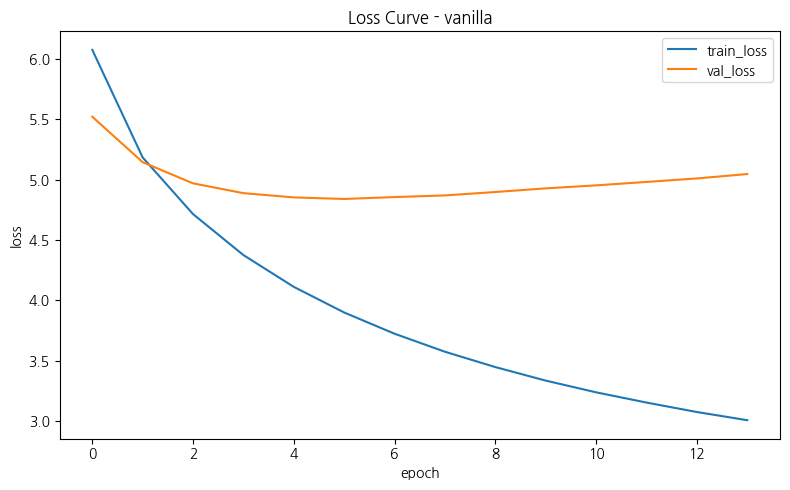


Training: bahdanau



[bahdanau] epoch 001 | train_loss=6.1858 | val_loss=5.5733
  K: 오바마는 대통령이다.
  P: he said he was not clear .
  K: 시민들은 도시 속에 산다.
  P: the ap ' s death toll .
  K: 커피는 필요 없다.
  P: the ap ' s not be able to be a lot .
  K: 일곱 명의 사망자가 발생했다.
  P: the government has been killed .
  ✅ saved best -> s2s_translation/checkpoints_wp25k\best_bahdanau.pt (val_loss=5.5733)



[bahdanau] epoch 002 | train_loss=5.2140 | val_loss=5.1180
  K: 오바마는 대통령이다.
  P: obama is a candidate of the president .
  K: 시민들은 도시 속에 산다.
  P: the two men are being used .
  K: 커피는 필요 없다.
  P: the ap ' s a lot of the world .
  K: 일곱 명의 사망자가 발생했다.
  P: the two men were killed .
  ✅ saved best -> s2s_translation/checkpoints_wp25k\best_bahdanau.pt (val_loss=5.1180)



[bahdanau] epoch 003 | train_loss=4.7066 | val_loss=4.9172
  K: 오바마는 대통령이다.
  P: obama is the first time .
  K: 시민들은 도시 속에 산다.
  P: the two men are in the area .
  K: 커피는 필요 없다.
  P: the company is not a good thing .
  K: 일곱 명의 사망자가 발생했다.
  P: the blasts were killed in the blast .
  ✅ saved best -> s2s_translation/checkpoints_wp25k\best_bahdanau.pt (val_loss=4.9172)



[bahdanau] epoch 004 | train_loss=4.3380 | val_loss=4.8164
  K: 오바마는 대통령이다.
  P: obama is the first time .
  K: 시민들은 도시 속에 산다.
  P: the city of the city of the city of the city .
  K: 커피는 필요 없다.
  P: it ' s not a very important .
  K: 일곱 명의 사망자가 발생했다.
  P: two people were injured .
  ✅ saved best -> s2s_translation/checkpoints_wp25k\best_bahdanau.pt (val_loss=4.8164)



[bahdanau] epoch 005 | train_loss=4.0446 | val_loss=4.7714
  K: 오바마는 대통령이다.
  P: obama is the president .
  K: 시민들은 도시 속에 산다.
  P: the two koreas are in the city of the city .
  K: 커피는 필요 없다.
  P: the company is not known .
  K: 일곱 명의 사망자가 발생했다.
  P: the deaths were killed in the blast .
  ✅ saved best -> s2s_translation/checkpoints_wp25k\best_bahdanau.pt (val_loss=4.7714)



[bahdanau] epoch 006 | train_loss=3.8053 | val_loss=4.7550
  K: 오바마는 대통령이다.
  P: obama is the president ' s .
  K: 시민들은 도시 속에 산다.
  P: some people are dead in the city .
  K: 커피는 필요 없다.
  P: it ' s not a matter .
  K: 일곱 명의 사망자가 발생했다.
  P: two people were injured .
  ✅ saved best -> s2s_translation/checkpoints_wp25k\best_bahdanau.pt (val_loss=4.7550)



[bahdanau] epoch 007 | train_loss=3.6064 | val_loss=4.7594
  K: 오바마는 대통령이다.
  P: obama is the president .
  K: 시민들은 도시 속에 산다.
  P: the city of the city is a major city .
  K: 커피는 필요 없다.
  P: it is not a matter of the matter .
  K: 일곱 명의 사망자가 발생했다.
  P: the deaths were evacuated from the area .
  (no improvement) patience 1/8



[bahdanau] epoch 008 | train_loss=3.4394 | val_loss=4.7775
  K: 오바마는 대통령이다.
  P: obama is the president .
  K: 시민들은 도시 속에 산다.
  P: the city of amusement park is a major city of cloth .
  K: 커피는 필요 없다.
  P: it is not known to be known .
  K: 일곱 명의 사망자가 발생했다.
  P: five people were injured .
  (no improvement) patience 2/8



[bahdanau] epoch 009 | train_loss=3.2966 | val_loss=4.8028
  K: 오바마는 대통령이다.
  P: obama is the president .
  K: 시민들은 도시 속에 산다.
  P: the city of amusement park is a major city of living in the city .
  K: 커피는 필요 없다.
  P: it is not known for the law .
  K: 일곱 명의 사망자가 발생했다.
  P: the deaths were killed in the blast .
  (no improvement) patience 3/8



[bahdanau] epoch 010 | train_loss=3.1709 | val_loss=4.8260
  K: 오바마는 대통령이다.
  P: obama is the president .
  K: 시민들은 도시 속에 산다.
  P: the city of amusement park is a major vegetable .
  K: 커피는 필요 없다.
  P: the fun is a good thing .
  K: 일곱 명의 사망자가 발생했다.
  P: five people were wounded in the attack .
  (no improvement) patience 4/8



[bahdanau] epoch 011 | train_loss=3.0654 | val_loss=4.8618
  K: 오바마는 대통령이다.
  P: obama is the only president .
  K: 시민들은 도시 속에 산다.
  P: locals are bracing for the sun .
  K: 커피는 필요 없다.
  P: the world is not known .
  K: 일곱 명의 사망자가 발생했다.
  P: the dead were killed and three others .
  (no improvement) patience 5/8



[bahdanau] epoch 012 | train_loss=2.9704 | val_loss=4.8857
  K: 오바마는 대통령이다.
  P: obama will be the president .
  K: 시민들은 도시 속에 산다.
  P: protesters are the only way to the city .
  K: 커피는 필요 없다.
  P: it is not a matter of the conversation .
  K: 일곱 명의 사망자가 발생했다.
  P: more than 100 people were injured .
  (no improvement) patience 6/8



[bahdanau] epoch 013 | train_loss=2.8868 | val_loss=4.9194
  K: 오바마는 대통령이다.
  P: obama is the president .
  K: 시민들은 도시 속에 산다.
  P: some protesters are in the city .
  K: 커피는 필요 없다.
  P: caffeine is not a good health .
  K: 일곱 명의 사망자가 발생했다.
  P: the dead were injured in the accident .
  (no improvement) patience 7/8



[bahdanau] epoch 014 | train_loss=2.8108 | val_loss=4.9542
  K: 오바마는 대통령이다.
  P: obama will pick up the president .
  K: 시민들은 도시 속에 산다.
  P: the city is a hub of the city .
  K: 커피는 필요 없다.
  P: caffeine is not a good health .
  K: 일곱 명의 사망자가 발생했다.
  P: the deaths were at the scene .
  (no improvement) patience 8/8
  🛑 Early stopping triggered at epoch 14 (best_val=4.7550)


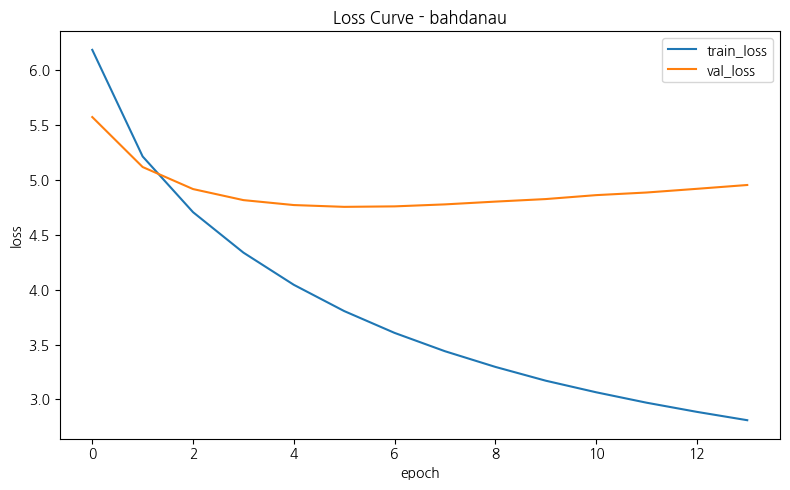


Training: luong



[luong] epoch 001 | train_loss=6.3113 | val_loss=5.8004
  K: 오바마는 대통령이다.
  P: the u . s . s . s . s . s . s . s . s . s . s . s . s . s . s . s . s .
  K: 시민들은 도시 속에 산다.
  P: the u . s . s . s . s . s . s . s . s . s .
  K: 커피는 필요 없다.
  P: the u . s . s . s .
  K: 일곱 명의 사망자가 발생했다.
  P: the u . s . s . s . s . s . s . s . s . s . s . s . s . s . s .
  ✅ saved best -> s2s_translation/checkpoints_wp25k\best_luong.pt (val_loss=5.8004)



[luong] epoch 002 | train_loss=5.4623 | val_loss=5.2851
  K: 오바마는 대통령이다.
  P: obama is a key presidential nominee .
  K: 시민들은 도시 속에 산다.
  P: the ap ' s largest automaker is the first time .
  K: 커피는 필요 없다.
  P: it ' s not yet .
  K: 일곱 명의 사망자가 발생했다.
  P: the dow is a number of the year .
  ✅ saved best -> s2s_translation/checkpoints_wp25k\best_luong.pt (val_loss=5.2851)



[luong] epoch 003 | train_loss=4.9462 | val_loss=5.0232
  K: 오바마는 대통령이다.
  P: obama is the first time in the white house .
  K: 시민들은 도시 속에 산다.
  P: the world ' s most famous is a long - term .
  K: 커피는 필요 없다.
  P: it ' s not a good thing .
  K: 일곱 명의 사망자가 발생했다.
  P: the dead were killed in the capital .
  ✅ saved best -> s2s_translation/checkpoints_wp25k\best_luong.pt (val_loss=5.0232)



[luong] epoch 004 | train_loss=4.5560 | val_loss=4.8823
  K: 오바마는 대통령이다.
  P: obama is the first time in the white house .
  K: 시민들은 도시 속에 산다.
  P: the storm is a very dangerous .
  K: 커피는 필요 없다.
  P: it ' s not a good thing .
  K: 일곱 명의 사망자가 발생했다.
  P: the death toll is a major earthquake .
  ✅ saved best -> s2s_translation/checkpoints_wp25k\best_luong.pt (val_loss=4.8823)



[luong] epoch 005 | train_loss=4.2372 | val_loss=4.8044
  K: 오바마는 대통령이다.
  P: obama is the president ' s .
  K: 시민들은 도시 속에 산다.
  P: the city is the largest city of the world .
  K: 커피는 필요 없다.
  P: it ' s not a lot of the things .
  K: 일곱 명의 사망자가 발생했다.
  P: the dead were killed in the capital .
  ✅ saved best -> s2s_translation/checkpoints_wp25k\best_luong.pt (val_loss=4.8044)



[luong] epoch 006 | train_loss=3.9734 | val_loss=4.7723
  K: 오바마는 대통령이다.
  P: obama is to be in the white house .
  K: 시민들은 도시 속에 산다.
  P: the world ' s largest cities is a city .
  K: 커피는 필요 없다.
  P: it ' s not a good thing .
  K: 일곱 명의 사망자가 발생했다.
  P: the dead were killed in the hospital .
  ✅ saved best -> s2s_translation/checkpoints_wp25k\best_luong.pt (val_loss=4.7723)



[luong] epoch 007 | train_loss=3.7528 | val_loss=4.7631
  K: 오바마는 대통령이다.
  P: obama is expected to answer the president .
  K: 시민들은 도시 속에 산다.
  P: the world ' s largest city of snow .
  K: 커피는 필요 없다.
  P: i ' m not going to do .
  K: 일곱 명의 사망자가 발생했다.
  P: the death toll of the dead were killed .
  ✅ saved best -> s2s_translation/checkpoints_wp25k\best_luong.pt (val_loss=4.7631)



[luong] epoch 008 | train_loss=3.5681 | val_loss=4.7788
  K: 오바마는 대통령이다.
  P: obama is expected to attend the president .
  K: 시민들은 도시 속에 산다.
  P: the city ' s main drag .
  K: 커피는 필요 없다.
  P: there ' s no way to do .
  K: 일곱 명의 사망자가 발생했다.
  P: the deaths were killed in the attack .
  (no improvement) patience 1/8



[luong] epoch 009 | train_loss=3.4132 | val_loss=4.7924
  K: 오바마는 대통령이다.
  P: obama will be the president .
  K: 시민들은 도시 속에 산다.
  P: the city ' s urban city .
  K: 커피는 필요 없다.
  P: there ' s no doubt that the whole thing .
  K: 일곱 명의 사망자가 발생했다.
  P: the dead were killed in the accident .
  (no improvement) patience 2/8



[luong] epoch 010 | train_loss=3.2820 | val_loss=4.8212
  K: 오바마는 대통령이다.
  P: obama will be the president ' s president .
  K: 시민들은 도시 속에 산다.
  P: the city ' s urban cities are not necessarily .
  K: 커피는 필요 없다.
  P: if you ' re not going to do .
  K: 일곱 명의 사망자가 발생했다.
  P: the deaths were killed in the accident .
  (no improvement) patience 3/8



[luong] epoch 011 | train_loss=3.1685 | val_loss=4.8441
  K: 오바마는 대통령이다.
  P: obama will be the president .
  K: 시민들은 도시 속에 산다.
  P: the city hall is the most urgent .
  K: 커피는 필요 없다.
  P: if you ' re going to do .
  K: 일곱 명의 사망자가 발생했다.
  P: the dead were injured .
  (no improvement) patience 4/8



[luong] epoch 012 | train_loss=3.0698 | val_loss=4.8763
  K: 오바마는 대통령이다.
  P: obama is currently on the white house .
  K: 시민들은 도시 속에 산다.
  P: the cities are also used to be used .
  K: 커피는 필요 없다.
  P: if you ' re not going to go .
  K: 일곱 명의 사망자가 발생했다.
  P: the number of deaths were wounded .
  (no improvement) patience 5/8



[luong] epoch 013 | train_loss=2.9833 | val_loss=4.9137
  K: 오바마는 대통령이다.
  P: obama is currently on the president .
  K: 시민들은 도시 속에 산다.
  P: cities are the torch relay .
  K: 커피는 필요 없다.
  P: if you ' re going to do .
  K: 일곱 명의 사망자가 발생했다.
  P: two people were injured .
  (no improvement) patience 6/8



[luong] epoch 014 | train_loss=2.9063 | val_loss=4.9327
  K: 오바마는 대통령이다.
  P: obama is campaigning on his ballot
  K: 시민들은 도시 속에 산다.
  P: cities are the only one .
  K: 커피는 필요 없다.
  P: if you ' re not going to go .
  K: 일곱 명의 사망자가 발생했다.
  P: the accident happened in the accident .
  (no improvement) patience 7/8



[luong] epoch 015 | train_loss=2.8380 | val_loss=4.9679
  K: 오바마는 대통령이다.
  P: obama is campaigning on president bush .
  K: 시민들은 도시 속에 산다.
  P: cities are bracing for the holidays .
  K: 커피는 필요 없다.
  P: if you ' re going to do .
  K: 일곱 명의 사망자가 발생했다.
  P: the dead were injured .
  (no improvement) patience 8/8
  🛑 Early stopping triggered at epoch 15 (best_val=4.7631)


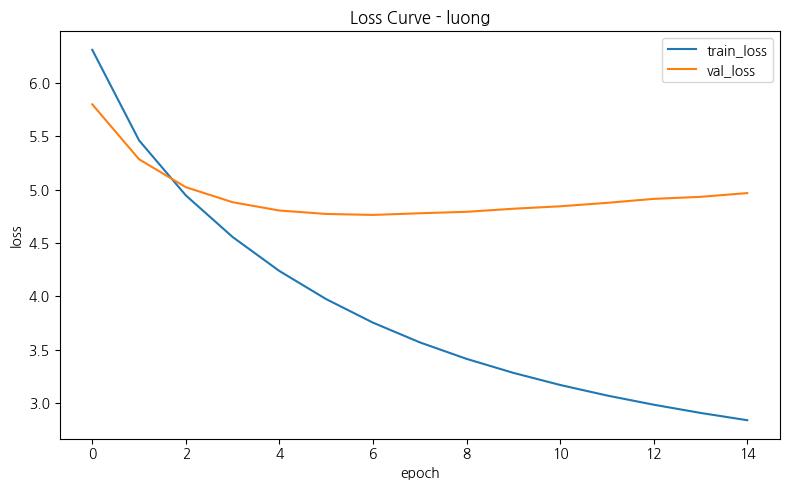


[OK] best checkpoints: {'vanilla': 's2s_translation/checkpoints_wp25k\\best_vanilla.pt', 'bahdanau': 's2s_translation/checkpoints_wp25k\\best_bahdanau.pt', 'luong': 's2s_translation/checkpoints_wp25k\\best_luong.pt'}


In [62]:
# ============================================================
# [STEP5-CELL 4] Fit 3 models (epochs=100 + early stopping) + loss curves 저장
# - ✅ 러닝커브(loss) 반드시 출력/시각화
# ============================================================
SAMPLES_KOR = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

def fit_model(model_name, model):
    optimizer = optim.Adam(model.parameters(), lr=LR)

    best_val = float("inf")
    best_path = os.path.join(SAVE_DIR, f"best_{model_name}.pt")

    train_losses = []
    val_losses = []

    patience_cnt = 0

    for epoch in range(1, EPOCHS + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer)
        val_loss = eval_one_epoch(model, dev_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"\n[{model_name}] epoch {epoch:03d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

        # 샘플 번역 출력
        for s in SAMPLES_KOR:
            pred, _ = sample_translate(model, s)
            print("  K:", s)
            print("  P:", pred)

        # best save + early stopping 관리
        improved = (best_val - val_loss) > MIN_DELTA
        if improved:
            best_val = val_loss
            patience_cnt = 0
            torch.save(
                {"model": model.state_dict(),
                 "epoch": epoch,
                 "best_val": best_val,
                 "train_loss": train_loss,
                 "val_loss": val_loss},
                best_path
            )
            print(f"  ✅ saved best -> {best_path} (val_loss={best_val:.4f})")
        else:
            patience_cnt += 1
            print(f"  (no improvement) patience {patience_cnt}/{EARLY_STOP_PATIENCE}")

        if patience_cnt >= EARLY_STOP_PATIENCE:
            print(f"  🛑 Early stopping triggered at epoch {epoch} (best_val={best_val:.4f})")
            break

    # 러닝 커브(LOSS) 시각화
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="train_loss")
    plt.plot(val_losses, label="val_loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title(f"Loss Curve - {model_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return best_path, (train_losses, val_losses)

best_paths = {}
loss_curves = {}

for name, model in models.items():
    print("\n" + "="*60)
    print("Training:", name)
    best_path, curves = fit_model(name, model)
    best_paths[name] = best_path
    loss_curves[name] = curves

print("\n[OK] best checkpoints:", best_paths)

[OK] loaded: s2s_translation/checkpoints_wp25k\best_vanilla.pt | epoch=6 | best_val=4.840398039136614
[OK] loaded: s2s_translation/checkpoints_wp25k\best_bahdanau.pt | epoch=6 | best_val=4.755016939980643
[OK] loaded: s2s_translation/checkpoints_wp25k\best_luong.pt | epoch=7 | best_val=4.763123512268066


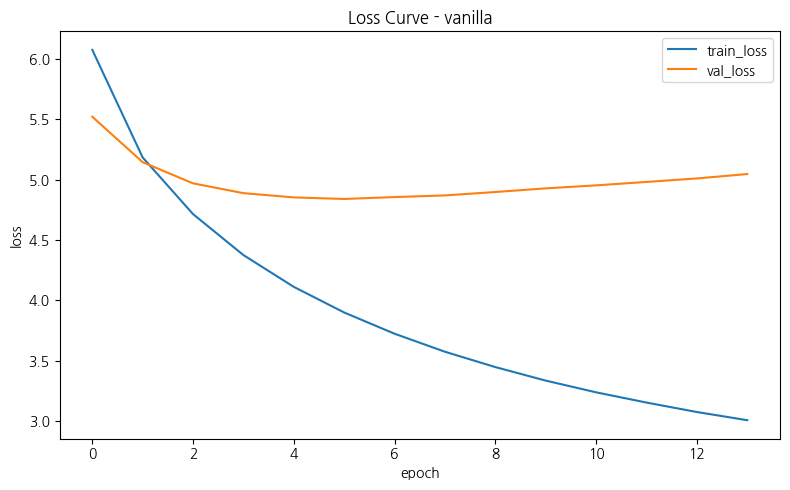

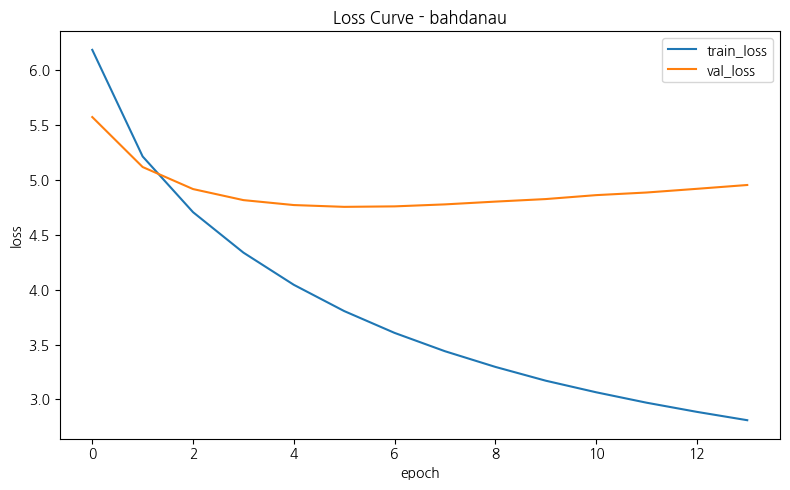

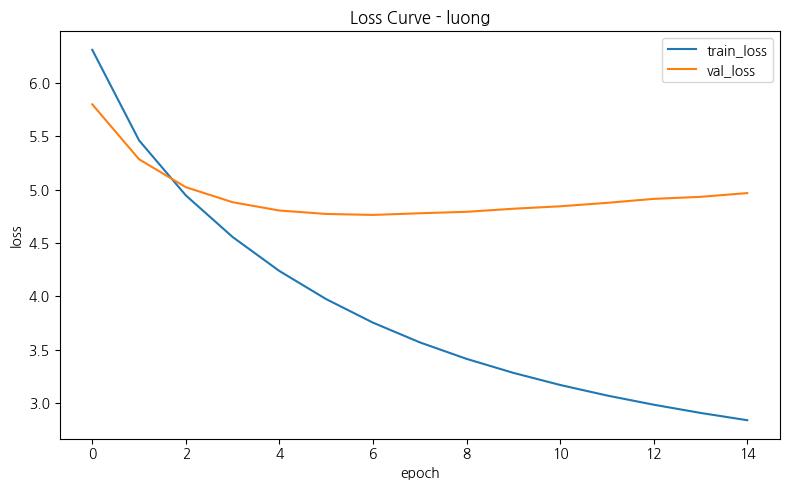

In [66]:
# ============================================================
# [STEP5-CELL 5] Load best 3 models + (보이게) 러닝커브 + 동일문장 평가 + attention 시각화
# - ✅ "---- 1) 3개 모델 로드 ----"
# - ✅ "---- 2) 러닝 커브 ----" 
# - ✅ "---- 3) 동일 문장으로 평가 --- 다음셀로 이동
# ============================================================
import torch

EVAL_SENTENCES = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다.",
]

def build_and_load_best(model_name: str):
    m = build_model(model_name)
    ckpt_path = os.path.join(SAVE_DIR, f"best_{model_name}.pt")
    ckpt = torch.load(ckpt_path, map_location=device)
    m.load_state_dict(ckpt["model"])
    m.eval()
    print(f"[OK] loaded: {ckpt_path} | epoch={ckpt.get('epoch', 'NA')} | best_val={ckpt.get('best_val', 'NA')}")
    return m

def has_attention(model_name: str) -> bool:
    return model_name in ("bahdanau", "luong")

@torch.no_grad()
def run_single(model, model_name: str, kor_sent: str):
    pred, attn = sample_translate(model, kor_sent)

    print(f"\n[{model_name}]")
    print("K:", kor_sent)
    print("P:", pred)

    if has_attention(model_name):
        plot_attention(attn, kor_sent, pred)

    return pred


# ---- 1) 3개 모델 로드 ----
loaded_models = {
    "vanilla": build_and_load_best("vanilla"),
    "bahdanau": build_and_load_best("bahdanau"),
    "luong": build_and_load_best("luong"),
}

# ---- 2) 러닝 커브 ----
# (학습을 이번 세션에서 fit_model로 돌렸다면 loss_curves에 있습니다.)
# 혹시 커널 재시작해서 loss_curves가 비어있으면, 최소한 모델별 best만 로드하고 3)평가만 진행됩니다.
if "loss_curves" in globals() and len(loss_curves) > 0:
    for name, (tr, va) in loss_curves.items():
        plt.figure(figsize=(8, 5))
        plt.plot(tr, label="train_loss")
        plt.plot(va, label="val_loss")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.title(f"Loss Curve - {name}")
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print("[WARN] loss_curves가 없습니다. (커널 재시작/학습 미실행 등) -> 러닝커브는 Step5-CELL4 실행 후 생성됩니다.")



Sentence: 오바마는 대통령이다.

[vanilla]
K: 오바마는 대통령이다.
P: obama is expected to be in the senate .

[bahdanau]
K: 오바마는 대통령이다.
P: obama is the president ' s .


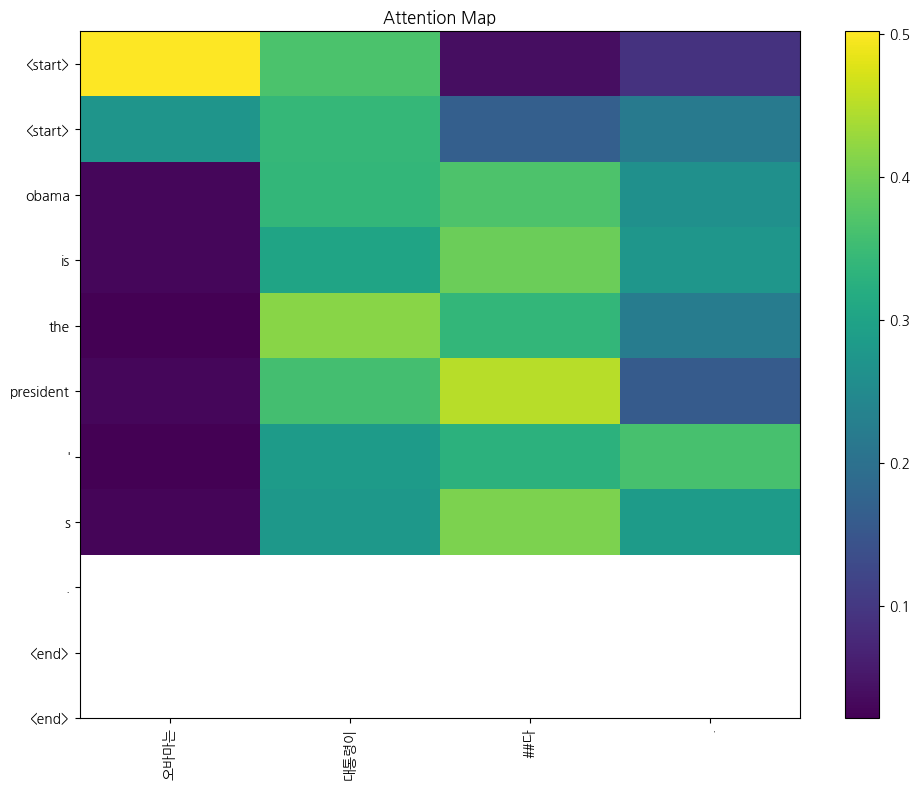


[luong]
K: 오바마는 대통령이다.
P: obama is expected to answer the president .


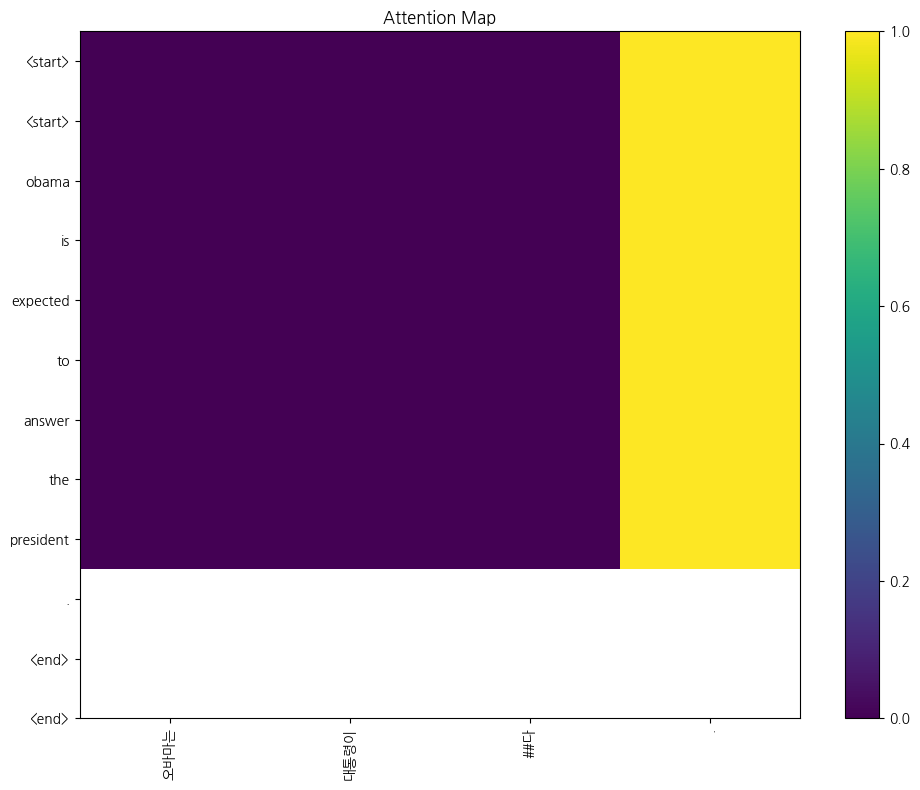


Sentence: 시민들은 도시 속에 산다.

[vanilla]
K: 시민들은 도시 속에 산다.
P: they are looking for a few days .

[bahdanau]
K: 시민들은 도시 속에 산다.
P: some people are dead in the city .


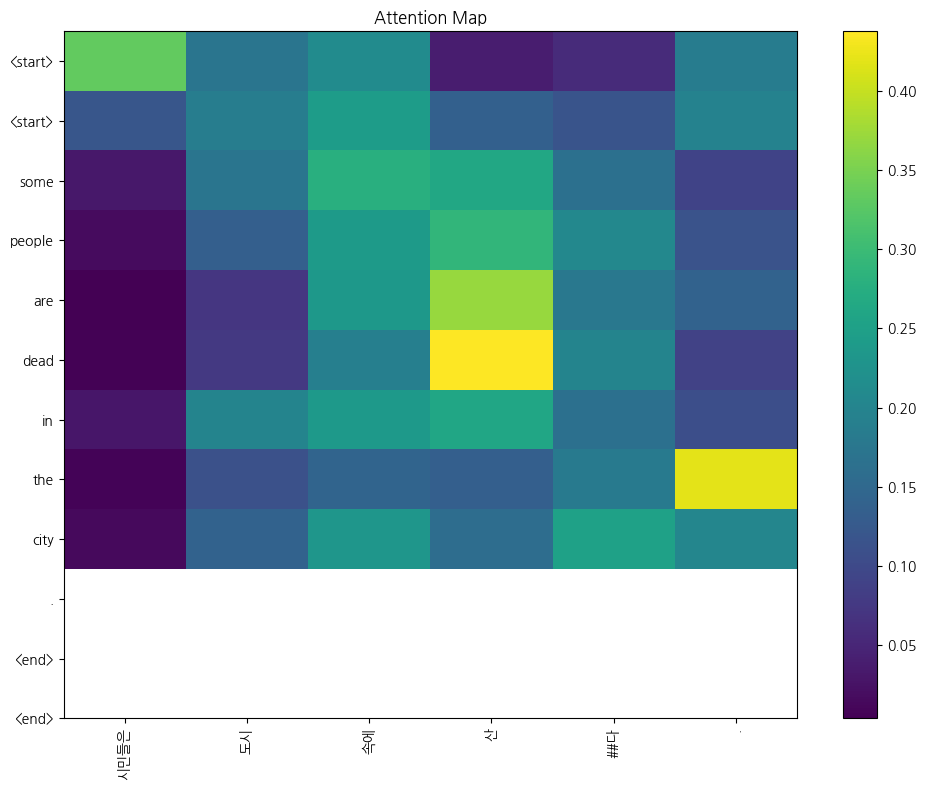


[luong]
K: 시민들은 도시 속에 산다.
P: the world ' s largest city of snow .


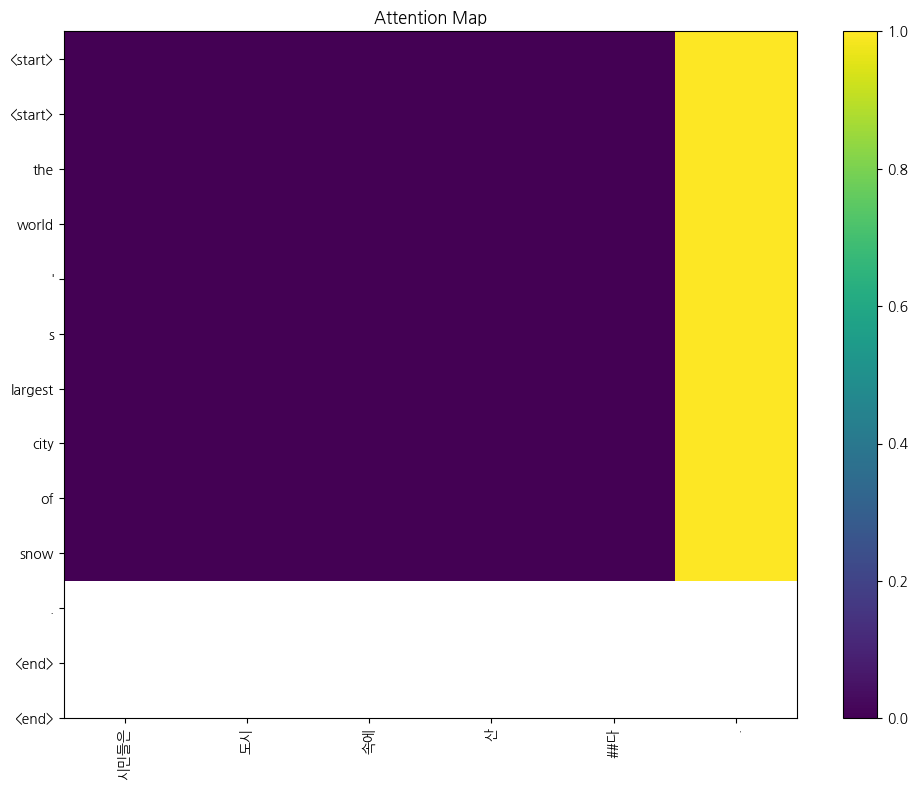


Sentence: 커피는 필요 없다.

[vanilla]
K: 커피는 필요 없다.
P: it is not clear how the money is not a problem .

[bahdanau]
K: 커피는 필요 없다.
P: it ' s not a matter .


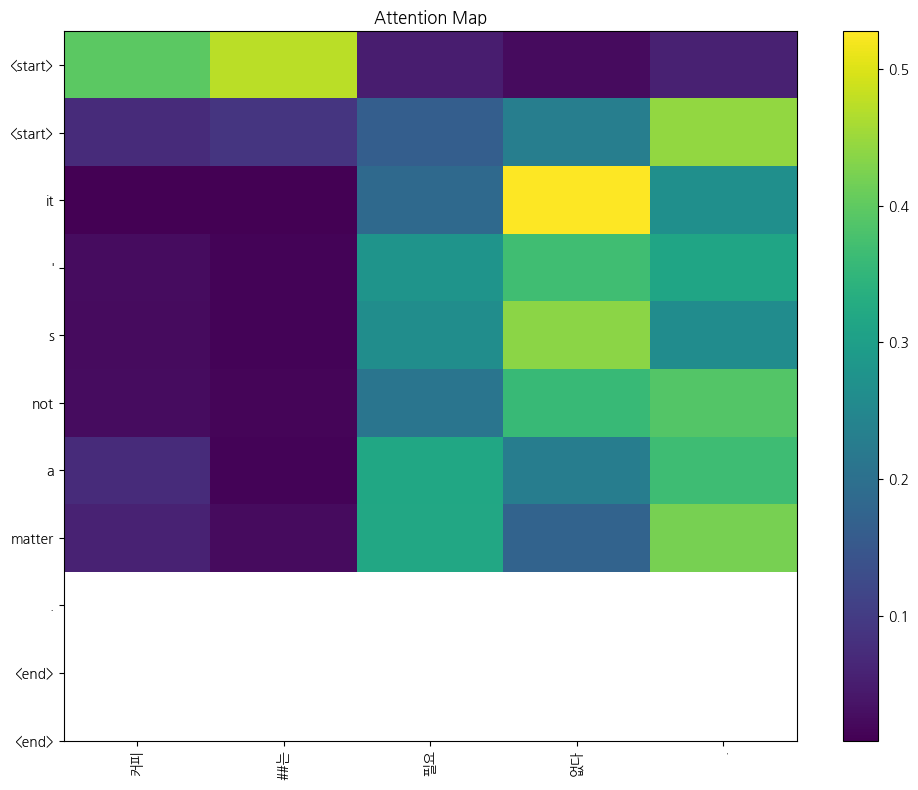


[luong]
K: 커피는 필요 없다.
P: i ' m not going to do .


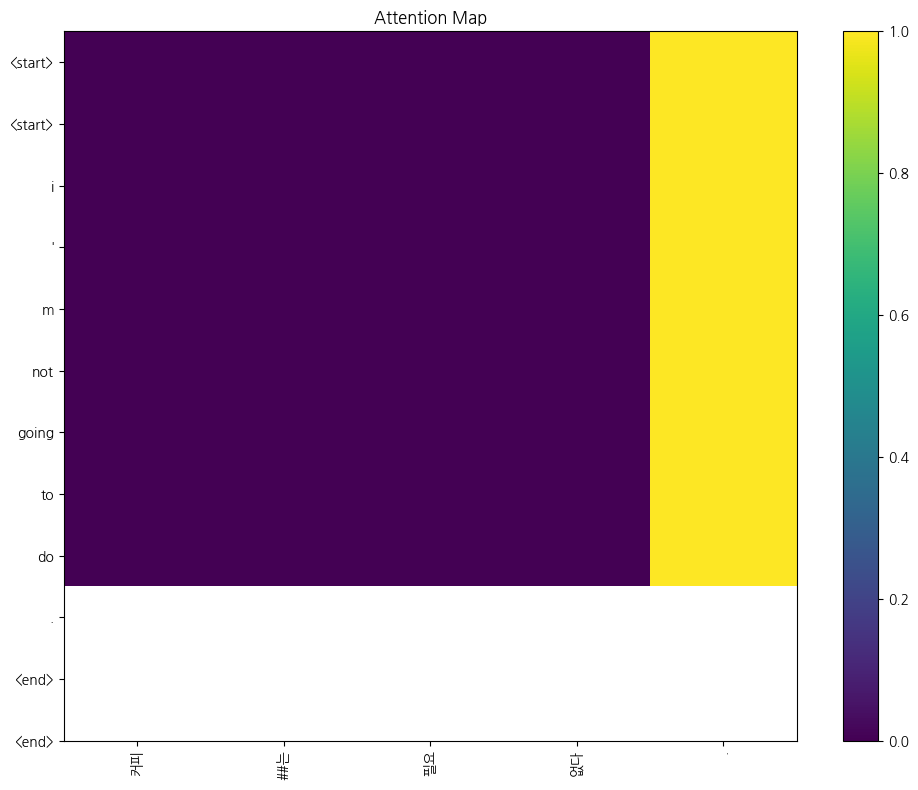


Sentence: 일곱 명의 사망자가 발생했다.

[vanilla]
K: 일곱 명의 사망자가 발생했다.
P: two people were killed and three wounded .

[bahdanau]
K: 일곱 명의 사망자가 발생했다.
P: two people were injured .


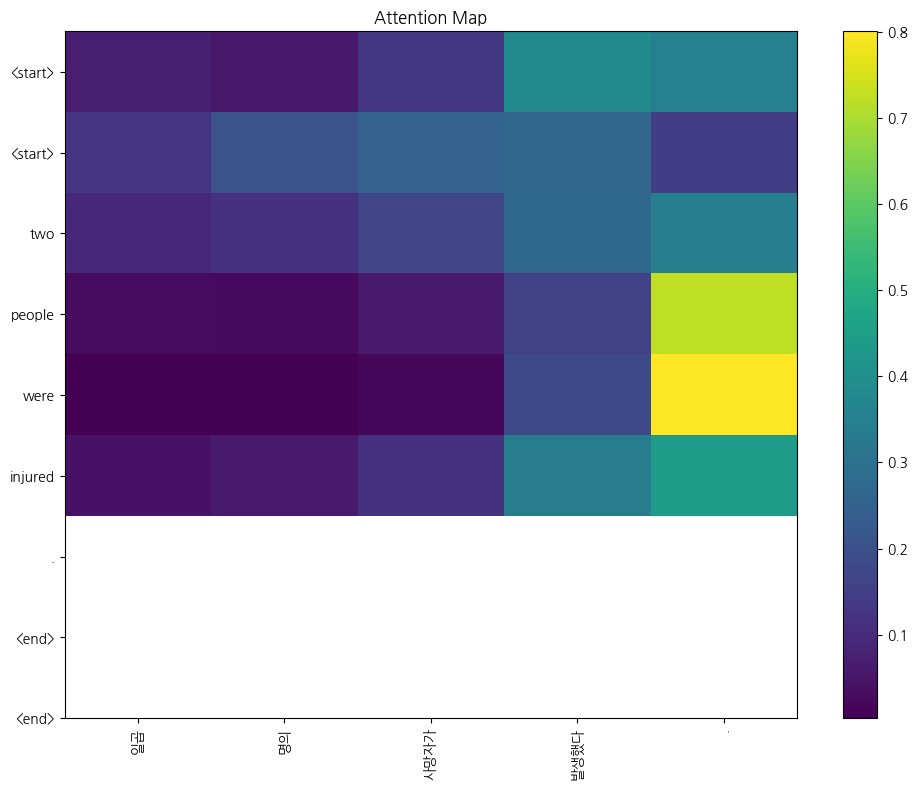


[luong]
K: 일곱 명의 사망자가 발생했다.
P: the death toll of the dead were killed .


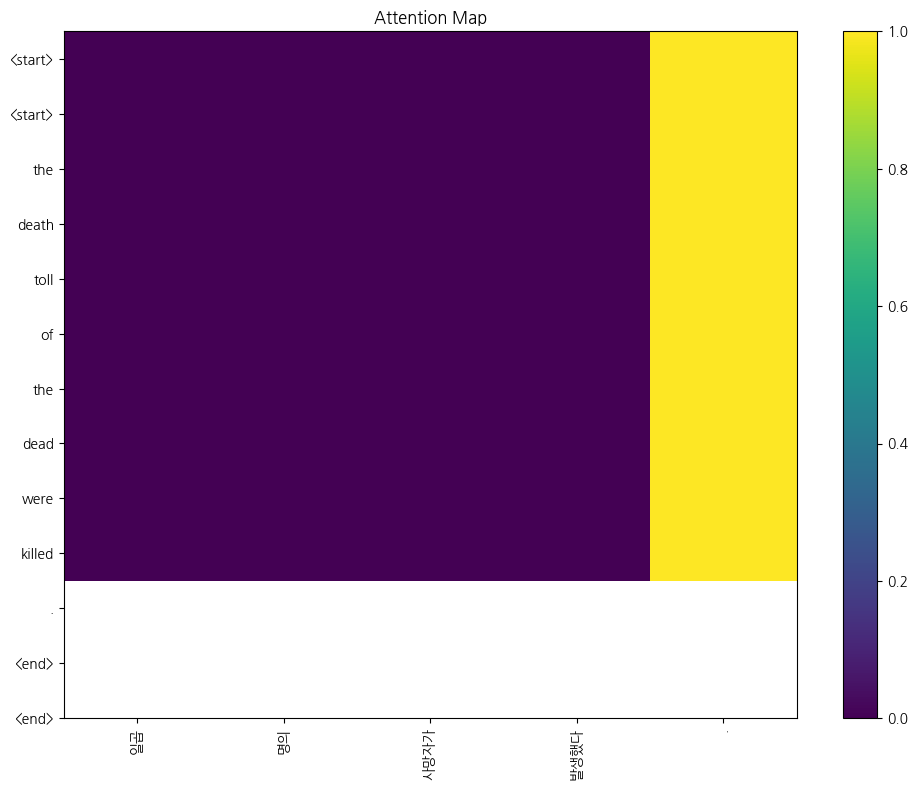

In [68]:
# ============================================================
# [STEP5-CELL 5] Load best 3 models + (보이게) 러닝커브 + 동일문장 평가 + attention 시각화
# - ✅ "---- 3) 동일 문장으로 평가 ----"
# ============================================================
# ---- 3) 동일 문장으로 평가 ----
for kor_sent in EVAL_SENTENCES:
    print("\n" + "="*70)
    print("Sentence:", kor_sent)
    print("="*70)
    for model_name in ("vanilla", "bahdanau", "luong"):
        run_single(loaded_models[model_name], model_name, kor_sent)

## Step 6 모델평가
- 어텐션 맵
- test dataset 전체에 대해 Corpus BLEU
- 보조 지표로 BLEU + chrF
- 3개 모델 성능 비교 및 에러 분석(짧은 문장/고유명사/부정문 등)

In [80]:
# ============================================================
# [STEP6] Corpus BLEU + chrF + (optional signature) + Error Analysis 강화
# - expects:
#   loaded_models: dict {"vanilla":..., "bahdanau":..., "luong":...}  (Step5에서 로드한 것)
#   test_kor, test_eng (문자열; eng는 "<start> ... <end>" 포함)
#   sample_translate(model, kor_sentence) -> (pred_str, attn)
# ============================================================
!pip -q install sacrebleu

import os
import re
import json
import numpy as np
import pandas as pd
import sacrebleu
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

EVAL_DIR = "s2s_translation/eval_outputs_wp25k"
os.makedirs(EVAL_DIR, exist_ok=True)


# ============================================================
# 1️⃣ Test 전체 생성
# ============================================================

def strip_tags(s):
    s = s.replace("<start>", "").replace("<end>", "").strip()
    return re.sub(r"\s+", " ", s)

refs_test = [strip_tags(s) for s in test_eng]

def generate_test(model, model_name):
    hyps = []
    rows = []

    print(f"\n[Generate] {model_name} on test: n={len(test_kor)}")
    for i, kor in enumerate(tqdm(test_kor)):
        pred, _ = sample_translate(model, kor)
        pred = pred.strip()
        hyps.append(pred)

        rows.append({
            "i": i,
            "kor": kor,
            "ref": refs_test[i],
            "hyp": pred
        })

    out_path = os.path.join(EVAL_DIR, f"test_{model_name}.jsonl")
    with open(out_path, "w", encoding="utf-8") as f:
        for r in rows:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")

    print("[OK] saved:", out_path)
    return hyps

hyps = {}
for name in ["vanilla", "bahdanau", "luong"]:
    hyps[name] = generate_test(loaded_models[name], name)

print("\n[OK] Generation done.")


[Generate] vanilla on test: n=1691


100%|██████████████████████████████████████████████████████████████████████████████| 1691/1691 [00:30<00:00, 55.15it/s]


[OK] saved: s2s_translation/eval_outputs_wp25k\test_vanilla.jsonl

[Generate] bahdanau on test: n=1691


100%|██████████████████████████████████████████████████████████████████████████████| 1691/1691 [00:54<00:00, 30.94it/s]


[OK] saved: s2s_translation/eval_outputs_wp25k\test_bahdanau.jsonl

[Generate] luong on test: n=1691


100%|██████████████████████████████████████████████████████████████████████████████| 1691/1691 [00:49<00:00, 34.51it/s]

[OK] saved: s2s_translation/eval_outputs_wp25k\test_luong.jsonl

[OK] Generation done.


In [81]:
# ============================================================
# 2️⃣ Corpus BLEU + chrF
# ============================================================

rows = []

for name in ["vanilla", "bahdanau", "luong"]:
    bleu = sacrebleu.corpus_bleu(hyps[name], [refs_test])
    chrf = sacrebleu.corpus_chrf(hyps[name], [refs_test])

    rows.append({
        "model": name,
        "BLEU": float(bleu.score),
        "chrF": float(chrf.score),
        "BLEU+chrF": float(bleu.score + chrf.score)
    })

score_table = pd.DataFrame(rows).sort_values("BLEU", ascending=False)
display(score_table)

print("\n[OK] Corpus metrics done.")


That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


,model,BLEU,chrF,BLEU+chrF
2,luong,2.700979,21.930951,24.631929
1,bahdanau,2.515505,22.292436,24.807941
0,vanilla,1.920166,21.081727,23.001894



[OK] Corpus metrics done.


In [82]:
# ============================================================
# 3️⃣ 정량 기반 에러 분석
# ============================================================

def sent_bleu(h, r):
    return sacrebleu.sentence_bleu(h, [r], smooth_method="exp").score

analysis = []

neg_pat = re.compile(r"(없|않|못|아니|말)")

for i in range(len(test_kor)):
    row = {
        "i": i,
        "kor": test_kor[i],
        "ref": refs_test[i],
        "short": len(test_kor[i].split()) <= 6,
        "neg": bool(neg_pat.search(test_kor[i]))
    }

    for name in ["vanilla", "bahdanau", "luong"]:
        row[f"bleu_{name}"] = sent_bleu(hyps[name][i], refs_test[i])

    analysis.append(row)

df = pd.DataFrame(analysis)

print("\n🔎 Short sentence 평균 BLEU")
display(df[df["short"]==True][["bleu_vanilla","bleu_bahdanau","bleu_luong"]].mean())

print("\n🔎 Negation sentence 평균 BLEU")
display(df[df["neg"]==True][["bleu_vanilla","bleu_bahdanau","bleu_luong"]].mean())


print("\n🔻 Worst 5 (bahdanau)")
display(df.nsmallest(5, "bleu_bahdanau")[["kor","ref"]])


print("\n[OK] Error analysis done.")



🔎 Short sentence 평균 BLEU


bleu_vanilla     4.560027
bleu_bahdanau    5.757577
bleu_luong       6.554203
dtype: float64


🔎 Negation sentence 평균 BLEU


bleu_vanilla     3.186636
bleu_bahdanau    3.478677
bleu_luong       3.723085
dtype: float64


🔻 Worst 5 (bahdanau)


,kor,ref
84,당신은 자식이 치료할 수 있는 병에 걸렸으나 약이 없어 죽은 적이 있는가?,has your child ever died of a treatable diseas...
246,절화를 위해 화분에 물 채우기,filling a vase for cut flowers
255,주의를 기울어야 하는 이유,why should you care?
706,제프 블레터 국제축구협회(FIFA) 회장이 맨체스터 유나이티드에서 활약하고 있는 크...,"london, england (cnn) cristiano ronaldo should..."
844,"MADRID, Spain (CNN) / 이수지",from cnn madrid bureau chief al goodman



[OK] Error analysis done.


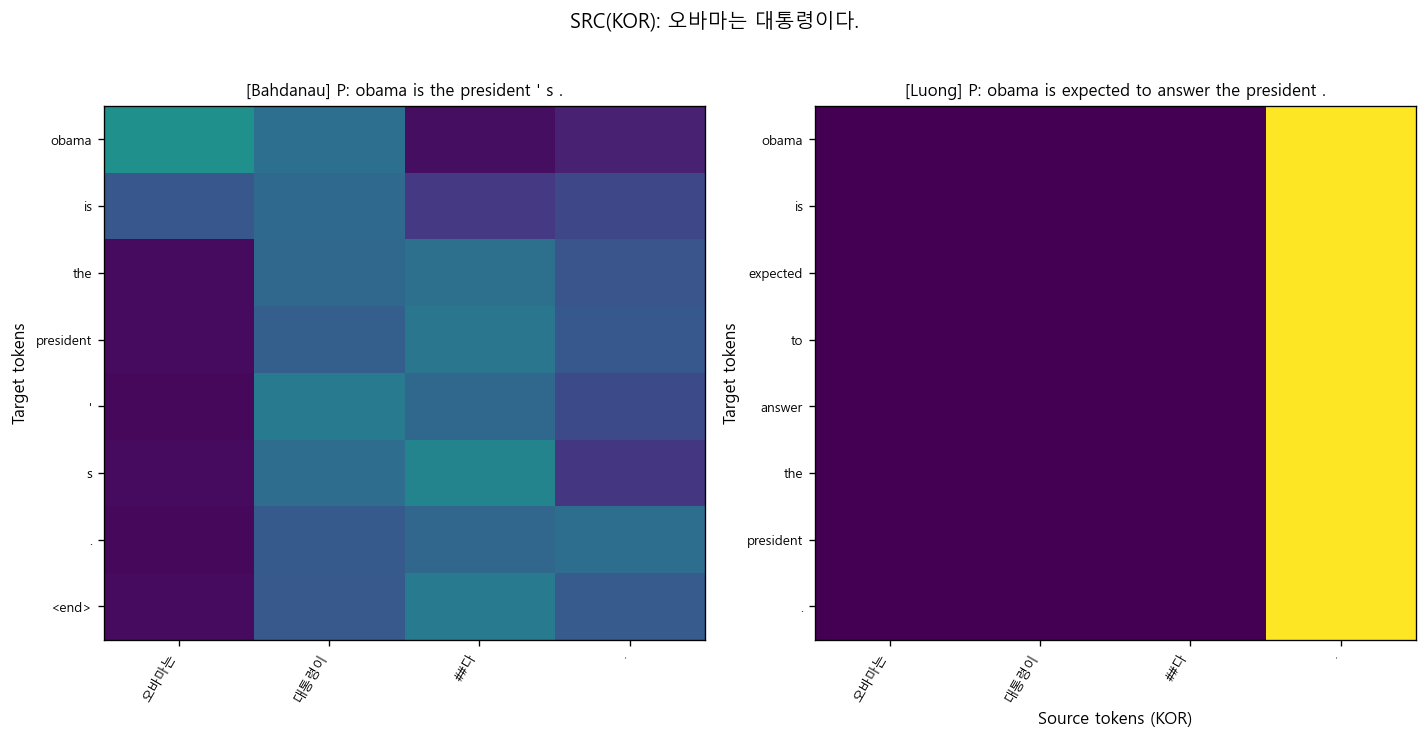


SRC(KOR): 오바마는 대통령이다.
[Bahdanau] P: obama is the president ' s .
[Luong]    P: obama is expected to answer the president .
------------------------------------------------------------------------------------------
[Hard alignment] (각 영어 토큰이 가장 많이 본 한국어 토큰)
  - w 값이 클수록(1에 가까울수록) 그 소스 토큰을 강하게 봤다는 뜻
  - 정상 패턴이면, tgt 진행에 따라 src 포커스가 이동(대각선 느낌)합니다.
------------------------------------------------------------------------------------------
Bahdanau:
         obama  ->  오바마는          (w=0.502)
            is  ->  대통령이          (w=0.342)
           the  ->  ##다           (w=0.369)
     president  ->  ##다           (w=0.393)
             '  ->  대통령이          (w=0.416)
             s  ->  ##다           (w=0.451)
             .  ->  .             (w=0.362)
         <end>  ->  ##다           (w=0.407)

Luong:
         obama  ->  .             (w=1.000)
            is  ->  .             (w=1.000)
      expected  ->  .             (w=1.000)
            to  ->  .             (w=1.000)
        answer 

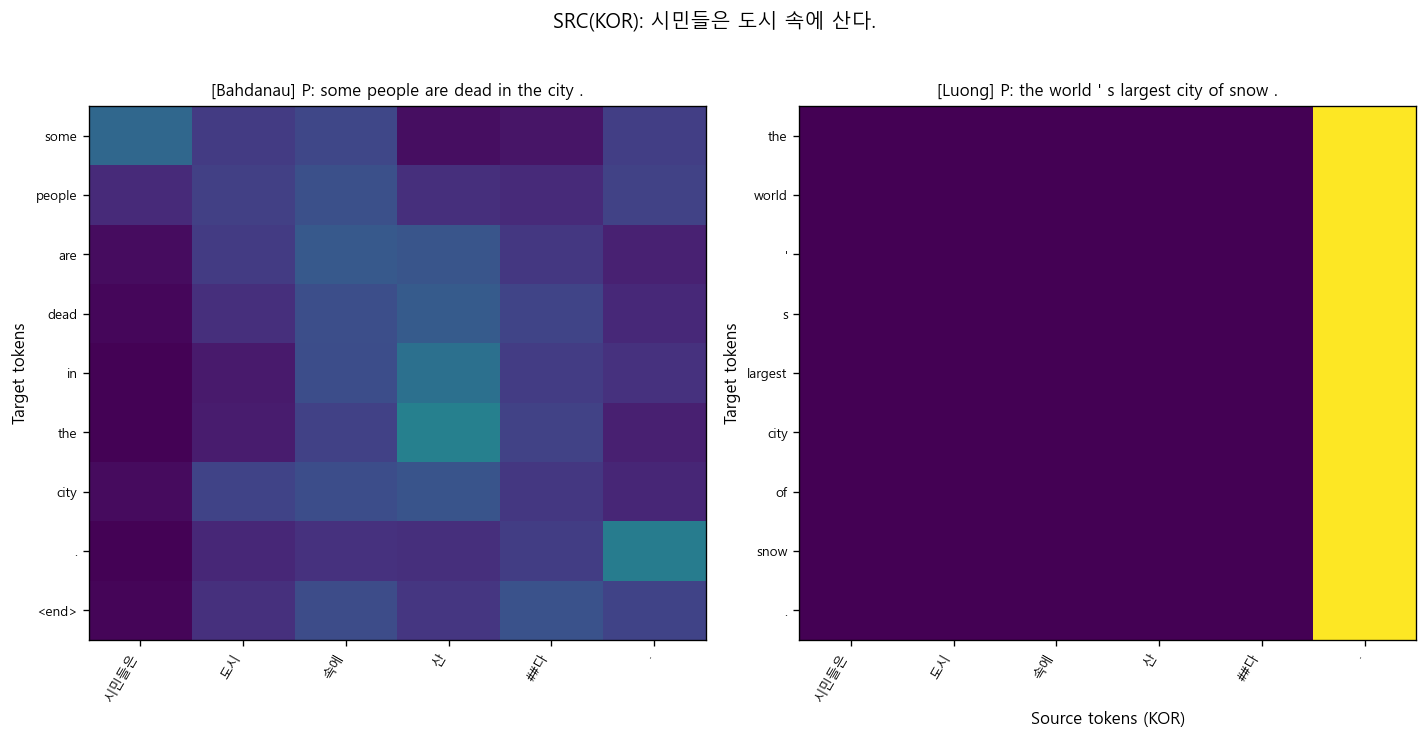


SRC(KOR): 시민들은 도시 속에 산다.
[Bahdanau] P: some people are dead in the city .
[Luong]    P: the world ' s largest city of snow .
------------------------------------------------------------------------------------------
[Hard alignment] (각 영어 토큰이 가장 많이 본 한국어 토큰)
  - w 값이 클수록(1에 가까울수록) 그 소스 토큰을 강하게 봤다는 뜻
  - 정상 패턴이면, tgt 진행에 따라 src 포커스가 이동(대각선 느낌)합니다.
------------------------------------------------------------------------------------------
Bahdanau:
          some  ->  시민들은          (w=0.333)
        people  ->  속에            (w=0.243)
           are  ->  속에            (w=0.277)
          dead  ->  산             (w=0.289)
            in  ->  산             (w=0.371)
           the  ->  산             (w=0.437)
          city  ->  산             (w=0.261)
             .  ->  .             (w=0.420)
         <end>  ->  ##다           (w=0.251)

Luong:
           the  ->  .             (w=1.000)
         world  ->  .             (w=1.000)
             '  ->  .             (w=1.000)
             

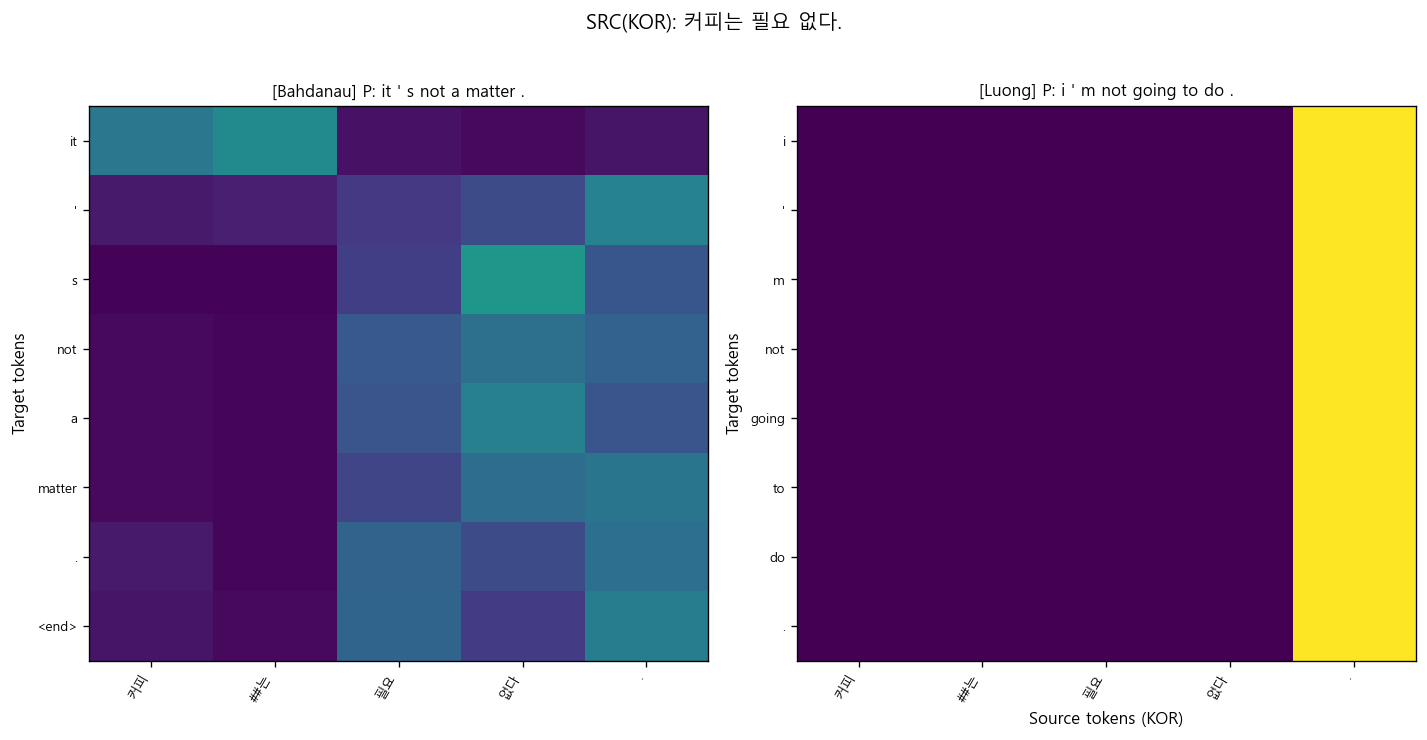


SRC(KOR): 커피는 필요 없다.
[Bahdanau] P: it ' s not a matter .
[Luong]    P: i ' m not going to do .
------------------------------------------------------------------------------------------
[Hard alignment] (각 영어 토큰이 가장 많이 본 한국어 토큰)
  - w 값이 클수록(1에 가까울수록) 그 소스 토큰을 강하게 봤다는 뜻
  - 정상 패턴이면, tgt 진행에 따라 src 포커스가 이동(대각선 느낌)합니다.
------------------------------------------------------------------------------------------
Bahdanau:
            it  ->  ##는           (w=0.475)
             '  ->  .             (w=0.443)
             s  ->  없다            (w=0.527)
           not  ->  없다            (w=0.369)
             a  ->  없다            (w=0.437)
        matter  ->  .             (w=0.389)
             .  ->  .             (w=0.366)
         <end>  ->  .             (w=0.422)

Luong:
             i  ->  .             (w=1.000)
             '  ->  .             (w=1.000)
             m  ->  .             (w=1.000)
           not  ->  .             (w=1.000)
         going  ->  .             (w=1.000)

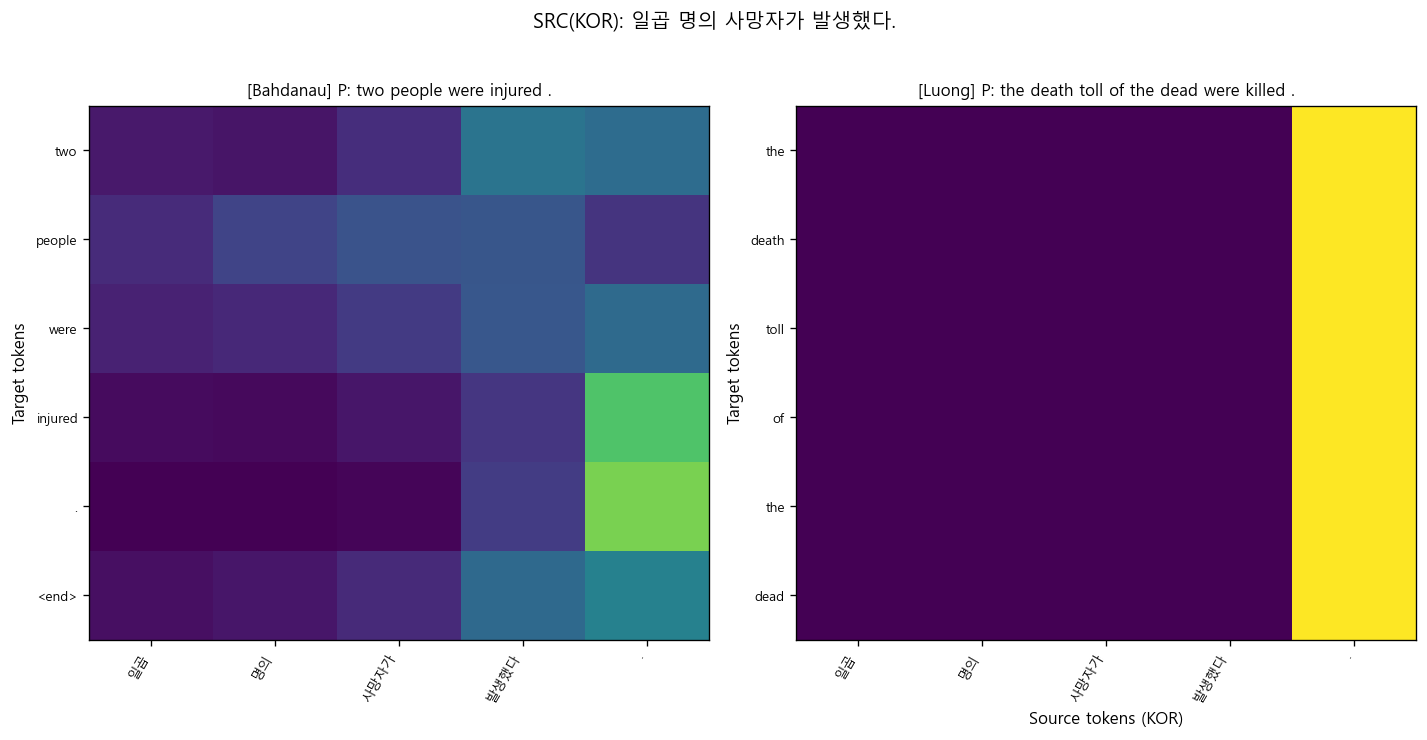


SRC(KOR): 일곱 명의 사망자가 발생했다.
[Bahdanau] P: two people were injured .
[Luong]    P: the death toll of the dead were killed .
------------------------------------------------------------------------------------------
[Hard alignment] (각 영어 토큰이 가장 많이 본 한국어 토큰)
  - w 값이 클수록(1에 가까울수록) 그 소스 토큰을 강하게 봤다는 뜻
  - 정상 패턴이면, tgt 진행에 따라 src 포커스가 이동(대각선 느낌)합니다.
------------------------------------------------------------------------------------------
Bahdanau:
           two  ->  발생했다          (w=0.386)
        people  ->  발생했다          (w=0.266)
          were  ->  .             (w=0.345)
       injured  ->  .             (w=0.725)
             .  ->  .             (w=0.801)
         <end>  ->  .             (w=0.439)

Luong:
           the  ->  .             (w=1.000)
         death  ->  .             (w=1.000)
          toll  ->  .             (w=1.000)
            of  ->  .             (w=1.000)
           the  ->  .             (w=1.000)
          dead  ->  .             (w=1.000)



In [148]:
# ============================================================
# 4️⃣ Attention Map (bahdanau vs luong) - pair view (per sentence)
# + shared colorbar + hard alignment print (top-k)
# + robust length alignment between attn_map and pred token labels
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import torch

EVAL_SENTENCES = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다.",
]

def _truncate_tokens(tokens, max_n=30):
    if len(tokens) <= max_n:
        return tokens, slice(0, len(tokens))
    return tokens[:max_n] + ["..."], slice(0, max_n)

# tokenizers(Tokenizers) reverse vocab: id -> token
ENG_ID2TOK = {i: t for t, i in tok_eng.get_vocab().items()}

def pred_ids_to_tokens(pred_ids, max_n=30):
    toks = []
    for i in pred_ids:
        i = int(i)
        if i == TGT_END_ID:
            toks.append("<end>")
            break
        if i == TGT_START_ID:
            toks.append("<start>")
            continue
        if i == TGT_PAD_ID:
            continue
        toks.append(ENG_ID2TOK.get(i, "<unk>"))
    return _truncate_tokens(toks, max_n=max_n)

def get_pred_and_attn(model, kor_sentence):
    src_ids = tok_kor.encode(kor_sentence).ids
    src_ids = pad_trunc(src_ids, MAX_SRC_LEN, SRC_PAD_ID)

    pred_ids, attn_map = greedy_decode(model, src_ids, max_len=MAX_TGT_LEN)  # attn_map: (T,S) or None
    pred_text = ids_to_text_eng(pred_ids)
    return pred_text, pred_ids, attn_map

def hard_alignment(attn_map, src_tokens, tgt_tokens, topk=1):
    """
    attn_map: (T,S)
    src_tokens: list[str] (S')
    tgt_tokens: list[str] (T')
    topk: 1 or more
    반환: list of lines (str)
    """
    lines = []
    T, S = attn_map.shape
    Tuse = min(T, len(tgt_tokens))
    for t in range(Tuse):
        a = attn_map[t]
        # src_tokens 길이와 맞춰 잘라서 topk
        Suse = min(len(src_tokens), S)
        a = a[:Suse]

        idxs = np.argsort(-a)[:topk]
        if topk == 1:
            idx = int(idxs[0])
            lines.append(f"{tgt_tokens[t]:>12s}  ->  {src_tokens[idx]:<12s}  (w={a[idx]:.3f})")
        else:
            tops = ", ".join([f"{src_tokens[int(i)]}(w={a[int(i)]:.2f})" for i in idxs])
            lines.append(f"{tgt_tokens[t]:>12s}  ->  {tops}")
    return lines

def plot_attention_pair(
    kor_sentence,
    max_src_tokens=28,
    max_tgt_tokens=22,
    show_colorbar=True,
    show_alignment=True,
    align_topk=1
):
    # 1) run models
    pred_b, pred_ids_b, attn_b = get_pred_and_attn(loaded_models["bahdanau"], kor_sentence)
    pred_l, pred_ids_l, attn_l = get_pred_and_attn(loaded_models["luong"], kor_sentence)

    if attn_b is None or attn_l is None:
        print("[WARN] attention map missing (should not happen for attn models).")
        return

    # 2) src tokens
    src_tokens_all = tok_kor.encode(kor_sentence).tokens
    src_tokens, src_sl = _truncate_tokens(src_tokens_all, max_src_tokens)

    # 3) tgt tokens aligned with pred_ids
    tgt_tokens_b, _ = pred_ids_to_tokens(pred_ids_b, max_n=max_tgt_tokens)
    tgt_tokens_l, _ = pred_ids_to_tokens(pred_ids_l, max_n=max_tgt_tokens)

    # (중요) attention map은 보통 "<start>" step을 포함하지 않습니다.
    # 따라서 라벨에서 <start>를 제거해서 step과 1:1 맞춥니다.
    if len(tgt_tokens_b) > 0 and tgt_tokens_b[0] == "<start>":
        tgt_tokens_b = tgt_tokens_b[1:]
    if len(tgt_tokens_l) > 0 and tgt_tokens_l[0] == "<start>":
        tgt_tokens_l = tgt_tokens_l[1:]

    # 4) slice attention matrices (robust)
    # attn_map shape: (T,S_total) where T=generated steps
    # src_sl은 token label 길이 기준, 실제 attn S랑 다를 수 있으니 clamp
    S_attn_b = attn_b.shape[1]
    S_attn_l = attn_l.shape[1]
    S_attn = min(S_attn_b, S_attn_l)  # 둘 중 더 짧은 쪽에 맞춤

    # src slice clamp
    src_start = src_sl.start if isinstance(src_sl, slice) else 0
    src_stop  = src_sl.stop  if isinstance(src_sl, slice) else len(src_tokens)
    src_stop = min(src_stop, S_attn, len(src_tokens_all))  # attn과 실제 토큰 범위 모두 clamp
    src_start = min(src_start, src_stop)

    # 최종 src_tokens도 clamp 반영
    src_tokens = src_tokens_all[src_start:src_stop]
    if len(src_tokens) == 0:
        print("[WARN] src_tokens empty after clamping.")
        return

    # tgt length clamp (각 모델별)
    T_b = min(attn_b.shape[0], len(tgt_tokens_b))
    T_l = min(attn_l.shape[0], len(tgt_tokens_l))
    T_use = min(T_b, T_l)  # 두 모델 비교라 공통 길이로 맞춤
    if T_use <= 0:
        print("[WARN] no valid target steps to plot.")
        return

    tgt_tokens_b = tgt_tokens_b[:T_use]
    tgt_tokens_l = tgt_tokens_l[:T_use]

    A_b = attn_b[:T_use, src_start:src_stop]
    A_l = attn_l[:T_use, src_start:src_stop]

    # 5) plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=120)

    # Bahdanau
    ax0 = axes[0]
    im0 = ax0.imshow(A_b, aspect="auto", vmin=0.0, vmax=1.0)
    ax0.set_title(f"[Bahdanau] P: {pred_b}", fontsize=10)
    ax0.set_xticks(range(len(src_tokens)))
    ax0.set_xticklabels(src_tokens, rotation=60, ha="right", fontsize=8)
    ax0.set_yticks(range(len(tgt_tokens_b)))
    ax0.set_yticklabels(tgt_tokens_b, fontsize=8)
    ax0.set_ylabel("Target tokens")

    # Luong
    ax1 = axes[1]
    im1 = ax1.imshow(A_l, aspect="auto", vmin=0.0, vmax=1.0)
    ax1.set_title(f"[Luong] P: {pred_l}", fontsize=10)
    ax1.set_xticks(range(len(src_tokens)))
    ax1.set_xticklabels(src_tokens, rotation=60, ha="right", fontsize=8)
    ax1.set_yticks(range(len(tgt_tokens_l)))
    ax1.set_yticklabels(tgt_tokens_l, fontsize=8)
    ax1.set_ylabel("Target tokens")
    ax1.set_xlabel("Source tokens (KOR)")

    # shared colorbar
#    if show_colorbar:
#        cbar = fig.colorbar(im1, ax=axes.ravel().tolist(), shrink=0.85, pad=0.02)
#        cbar.set_label("Attention weight (row sums ~ 1)", rotation=90)

    plt.suptitle(f"SRC(KOR): {kor_sentence}", fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()

    # 6) alignment print (해석 기준을 텍스트로 같이 제공)
    if show_alignment:
        print("\n" + "="*90)
        print(f"SRC(KOR): {kor_sentence}")
        print(f"[Bahdanau] P: {pred_b}")
        print(f"[Luong]    P: {pred_l}")
        print("-"*90)

        print("[Hard alignment] (각 영어 토큰이 가장 많이 본 한국어 토큰)")
        print("  - w 값이 클수록(1에 가까울수록) 그 소스 토큰을 강하게 봤다는 뜻")
        print("  - 정상 패턴이면, tgt 진행에 따라 src 포커스가 이동(대각선 느낌)합니다.")
        print("-"*90)

        print("Bahdanau:")
        for line in hard_alignment(A_b, src_tokens, tgt_tokens_b, topk=align_topk):
            print(" ", line)

        print("\nLuong:")
        for line in hard_alignment(A_l, src_tokens, tgt_tokens_l, topk=align_topk):
            print(" ", line)
        print("="*90 + "\n")


# ✅ EVAL_SENTENCES 시각화 (두 모델 비교 + 해석용 alignment 출력)
for s in EVAL_SENTENCES:
    plot_attention_pair(
        s,
        max_src_tokens=28,
        max_tgt_tokens=22,
        show_colorbar=True,
        show_alignment=True,
        align_topk=1   # 원하시면 3으로 올리면 top-3가 같이 나옵니다.
    )

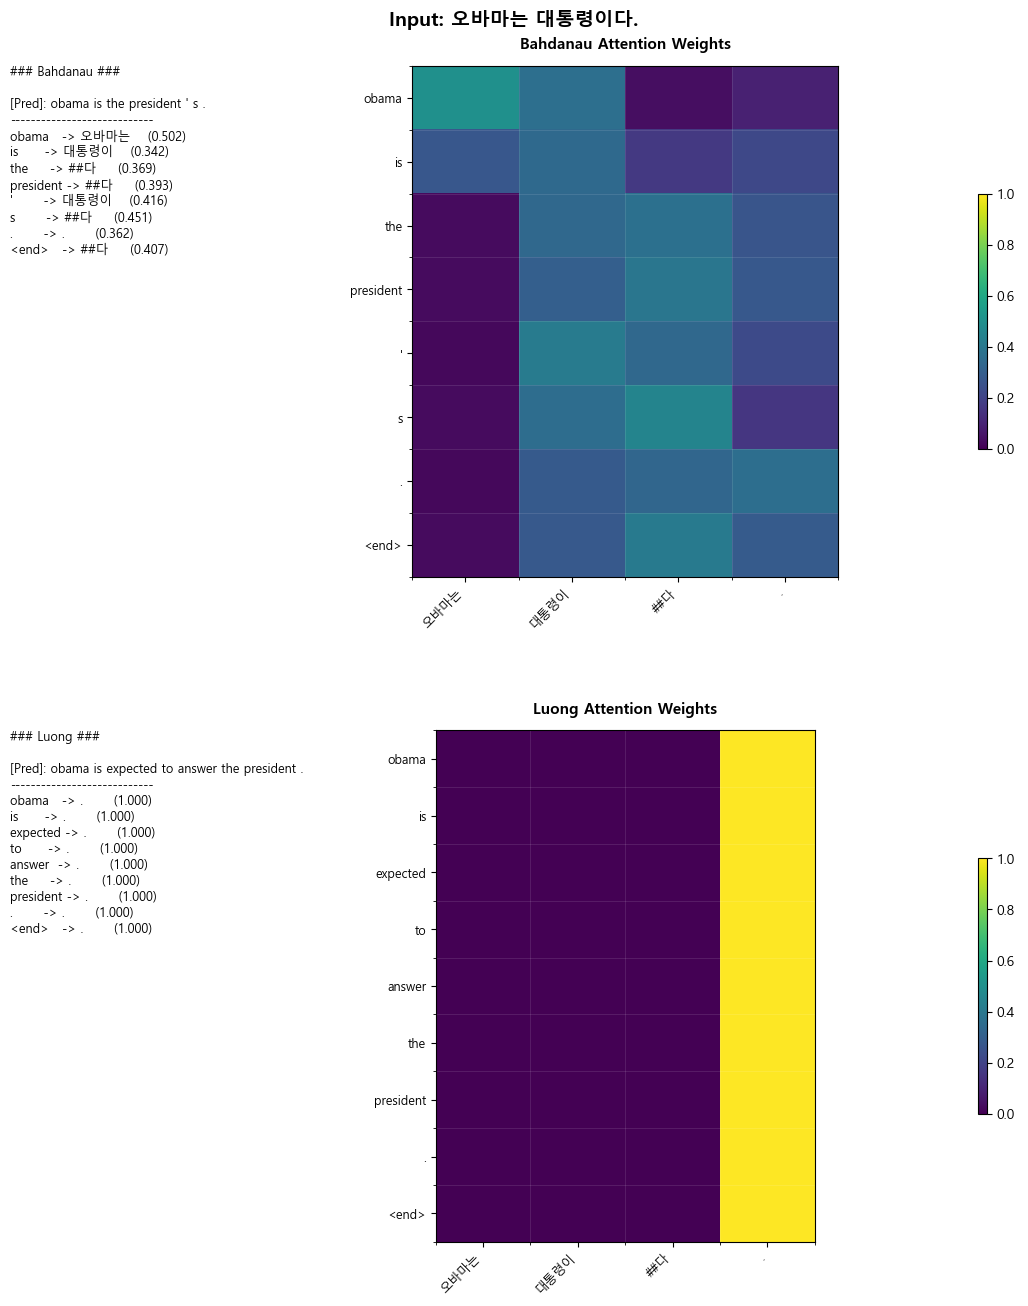

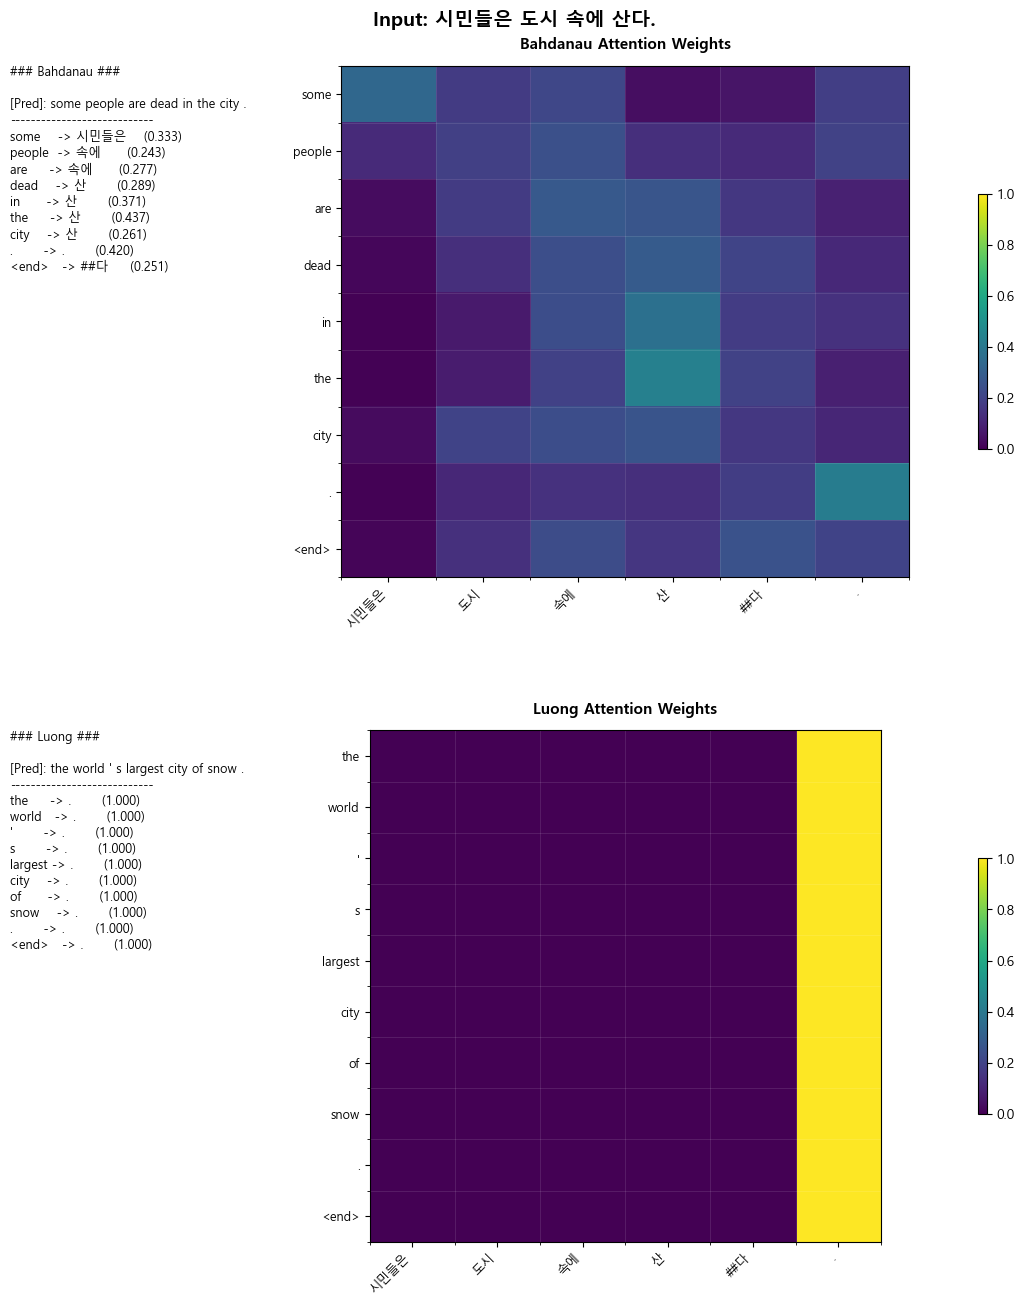

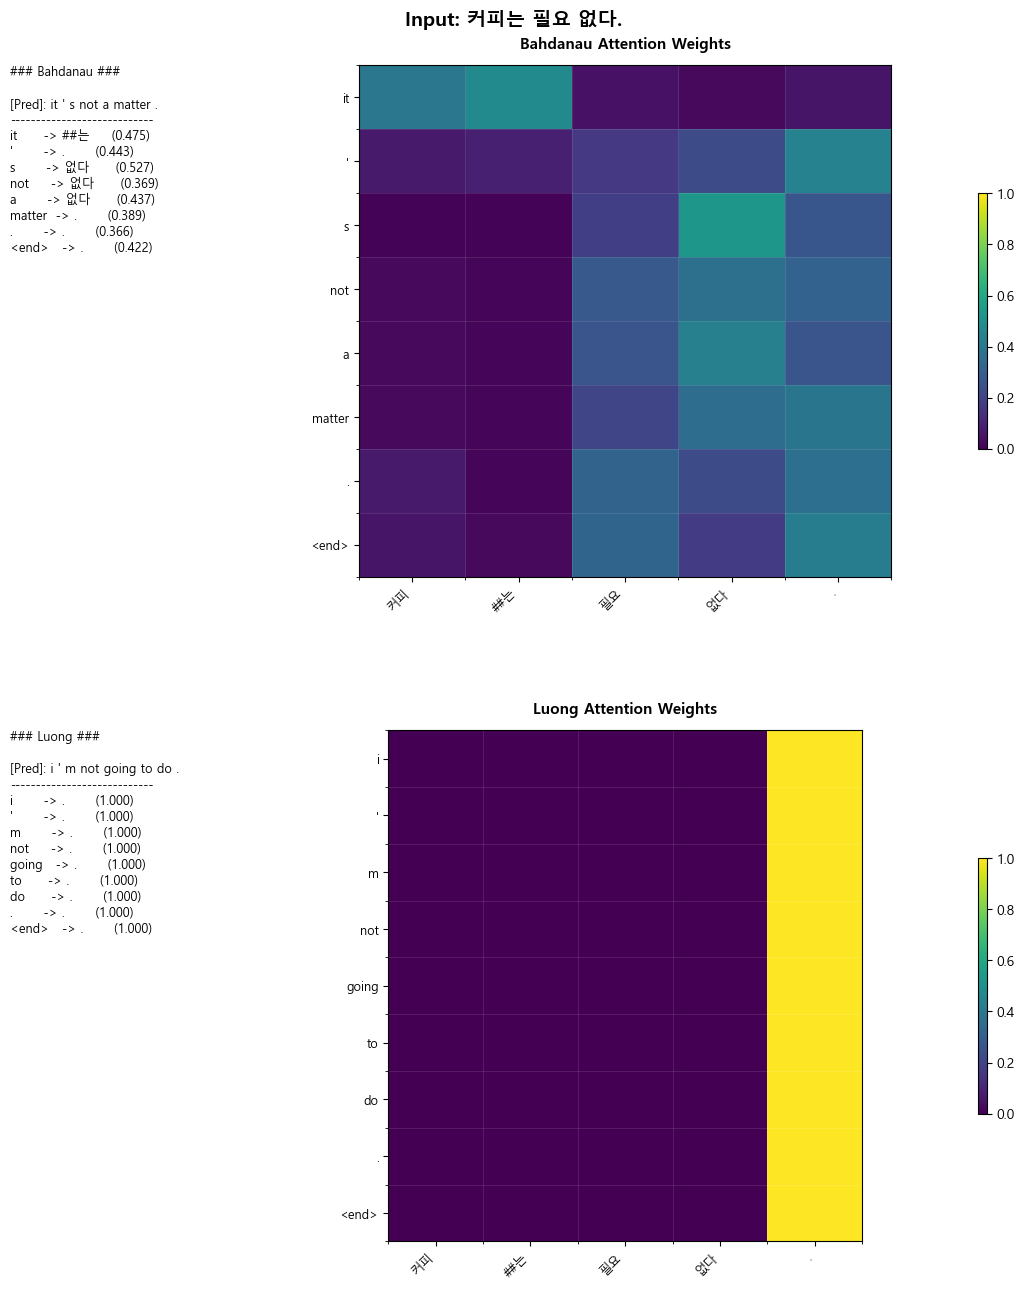

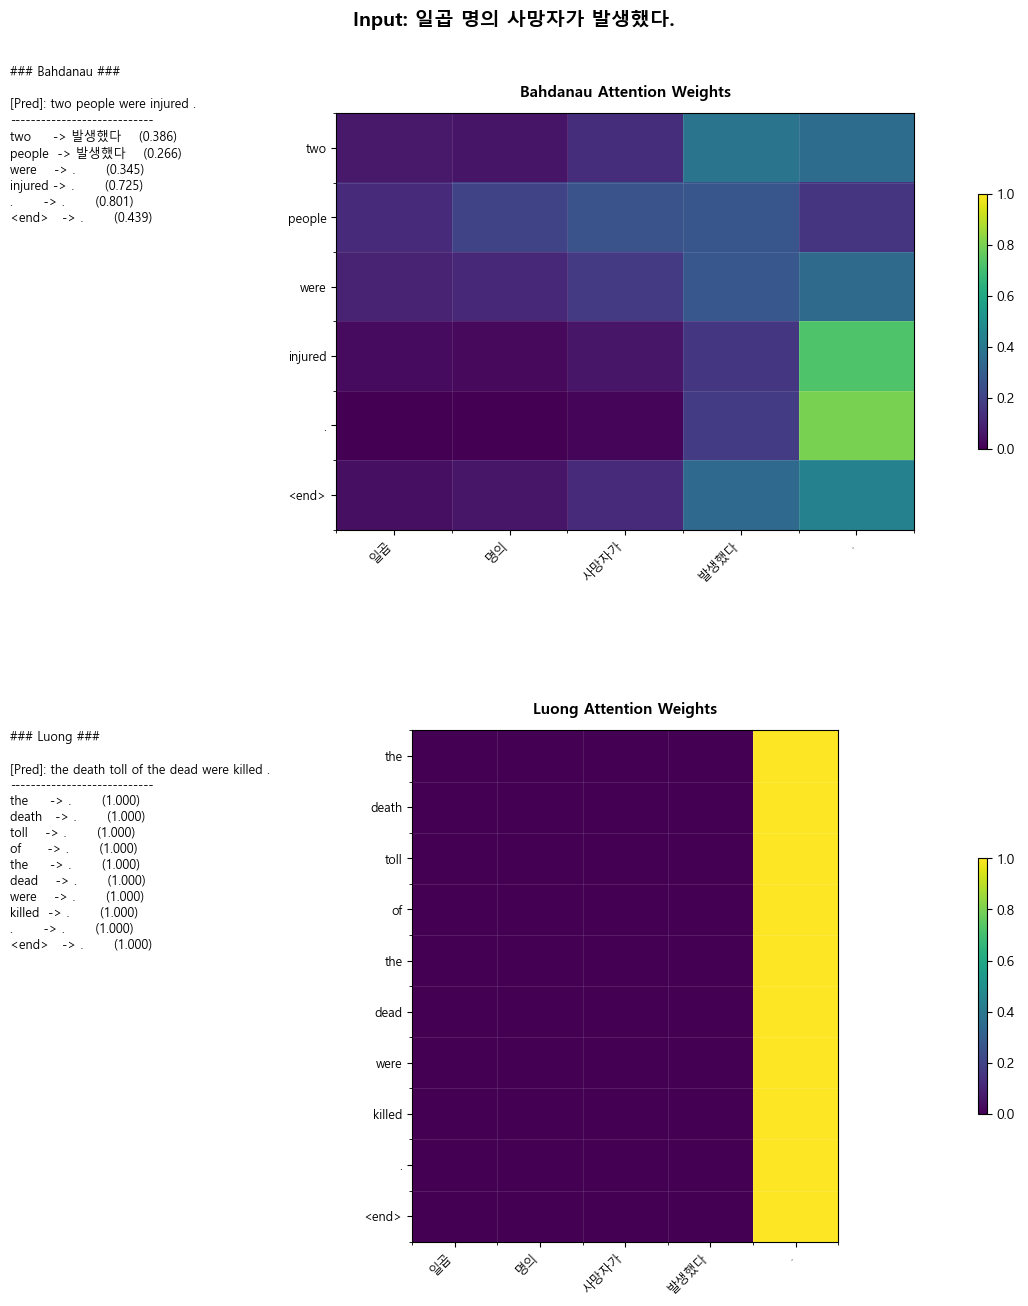

In [144]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# -----------------------------
# 0) Font setup (Korean + monospace)
# -----------------------------
def setup_fonts():
    installed = set(f.name for f in fm.fontManager.ttflist)
    prefer = ["D2Coding", "NanumGothicCoding", "Malgun Gothic", "NanumGothic", "AppleGothic"]
    chosen = None
    for name in prefer:
        if name in installed:
            chosen = name
            break
    if chosen:
        plt.rcParams["font.family"] = chosen
        plt.rcParams["font.monospace"] = ["D2Coding", "NanumGothicCoding", chosen, "Consolas", "DejaVu Sans Mono"]
        plt.rcParams["axes.unicode_minus"] = False
    else:
        plt.rcParams["axes.unicode_minus"] = False
setup_fonts()

# -----------------------------
# 1) Helpers (기존 로직 유지)
# -----------------------------
ENG_ID2TOK = {i: t for t, i in tok_eng.get_vocab().items()}

def pred_ids_to_tokens(pred_ids, max_n=30):
    toks = []
    for i in pred_ids:
        i = int(i)
        if i == TGT_START_ID: continue
        if i == TGT_PAD_ID: continue
        if i == TGT_END_ID:
            toks.append("<end>")
            break
        toks.append(ENG_ID2TOK.get(i, "<unk>"))
    return toks[:max_n]

def clamp_src_tokens(kor_sentence, attn_b, attn_l, max_src=28):
    src_all = tok_kor.encode(kor_sentence).tokens
    S = min(len(src_all), attn_b.shape[1], attn_l.shape[1], max_src)
    return src_all[:S], S

def hard_align(attn_map, src_tokens, tgt_tokens):
    lines = []
    T = min(attn_map.shape[0], len(tgt_tokens))
    S = min(attn_map.shape[1], len(src_tokens))
    for t in range(T):
        a = attn_map[t, :S]
        j = int(np.argmax(a))
        w = float(a[j])
        lines.append(f"{tgt_tokens[t]:<7s} -> {src_tokens[j]:<7s} ({w:.3f})")
    return lines

# -----------------------------
# 2) Drawing Logic (가시성 보완 버전)
# -----------------------------
def draw_model_row(fig, gs_row, title, pred, A, src_tokens, tgt_tokens, align_lines):
    ax_tbl = fig.add_subplot(gs_row[0])
    ax_hm  = fig.add_subplot(gs_row[1])
    ax_cb  = fig.add_subplot(gs_row[2])

    # ---- [Table Area] ----
    ax_tbl.axis("off")
    # 텍스트 가독성을 위해 줄간격(linespacing) 부여
    table_text = f"### {title} ###\n\n[Pred]: {pred}\n" + "-"*28 + "\n" + "\n".join(align_lines)
    ax_tbl.text(0.0, 1.0, table_text, va="top", ha="left", fontsize=9, family="monospace", linespacing=1.3)

    # ---- [Heatmap Area] (높이 강조 보완) ----
    # aspect 값을 1보다 크게 주면 세로(Y축)가 가로(X축) 대비 길어집니다. 
    # 문장 길이에 따라 aspect를 1.2~1.5 정도로 조정하면 세로로 길쭉해집니다.
    im = ax_hm.imshow(A, aspect= 0.6, cmap="viridis", vmin=0.0, vmax=1.0)
    ax_hm.set_title(f"{title} Attention Weights", fontsize=11, fontweight='bold', pad=12)
    
    # Tick Labels
    ax_hm.set_xticks(range(len(src_tokens)))
    ax_hm.set_xticklabels(src_tokens, rotation=45, ha="right", fontsize=9)
    ax_hm.set_yticks(range(len(tgt_tokens)))
    ax_hm.set_yticklabels(tgt_tokens, fontsize=9)
    
    # 그리드 가이드라인 (희미하게 유지)
    ax_hm.set_xticks(np.arange(-.5, len(src_tokens), 1), minor=True)
    ax_hm.set_yticks(np.arange(-.5, len(tgt_tokens), 1), minor=True)
    ax_hm.grid(which="minor", color="white", linestyle='-', linewidth=0.5, alpha=0.15)

    # ---- [Colorbar Area] ----
    ax_cb.axis("off")
    # 컬러바 위치를 히트맵 높이에 맞춰 슬림하게 조정
    cax = ax_cb.inset_axes([0.1, 0.25, 0.2, 0.5]) 
    fig.colorbar(im, cax=cax)

def plot_attn_rows(kor_sentence, max_src=28, max_tgt=22, figsize=(12, 14), dpi=100):
    # 1. 데이터 추출 (기존 로직)
    pred_b, pred_ids_b, attn_b = get_pred_and_attn(loaded_models["bahdanau"], kor_sentence)
    pred_l, pred_ids_l, attn_l = get_pred_and_attn(loaded_models["luong"], kor_sentence)
    if attn_b is None or attn_l is None: return

    src_tokens, S = clamp_src_tokens(kor_sentence, attn_b, attn_l, max_src=max_src)
    tgt_b = pred_ids_to_tokens(pred_ids_b, max_n=max_tgt)
    tgt_l = pred_ids_to_tokens(pred_ids_l, max_n=max_tgt)
    
    Tb, Tl = min(len(tgt_b), attn_b.shape[0]), min(len(tgt_l), attn_l.shape[0])
    A_b, A_l = attn_b[:Tb, :S], attn_l[:Tl, :S]
    lines_b = hard_align(A_b, src_tokens, tgt_b[:Tb])
    lines_l = hard_align(A_l, src_tokens, tgt_l[:Tl])

    # 2. Figure & GridSpec (보완 핵심: 세로 높이 확대 및 가로 제한)
    # figsize=(15, 12) -> 가로는 유지, 세로는 200% 키움(10->14)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = fig.add_gridspec(
        2, 3,
        height_ratios=[1, 1],
        width_ratios=[3.0, 6.5, 0.5], # 가로 비율에서 히트맵 비중을 살짝 줄여 횡 팽창 억제
        wspace=0.2, hspace=0.3
    )

    # Row 1: Bahdanau
    draw_model_row(fig, (gs[0, 0], gs[0, 1], gs[0, 2]), "Bahdanau", pred_b, A_b, src_tokens, tgt_b[:Tb], lines_b)
    
    # Row 2: Luong
    draw_model_row(fig, (gs[1, 0], gs[1, 1], gs[1, 2]), "Luong", pred_l, A_l, src_tokens, tgt_l[:Tl], lines_l)

    plt.suptitle(f"Input: {kor_sentence}", fontsize=14, fontweight='bold', y=0.96)
    plt.subplots_adjust(left=0.08, right=0.92, top=0.92, bottom=0.08)
    plt.show()

# 실행
for s in EVAL_SENTENCES:
    plot_attn_rows(s)